In [89]:
import numpy as np
import pandas as pd
from scipy.stats import t as student_t
import requests  # needed for API calls, if any

try:
    import numpy_financial as npf
except ImportError:
    npf = None

def get_required_margin(notional, maint_data):
    """
    Given a notional and a list of maintenance margin tiers (maint_data),
    compute the required margin using the tier formula:
    
        tier_margin = max(notional * maintMarginRate - maintAmount, 0)
    
    Then, compare this with the default margin (1/3 of the notional)
    and return the higher value.
    
    The function determines the appropriate tier by checking where
    notional falls within [notionalFloor, notionalCap). If notional exceeds
    all tiers, the last tier is used.
    """
    for tier in maint_data:
        if tier["notionalFloor"] <= notional < tier["notionalCap"]:
            tier_margin = max(notional * tier["maintMarginRate"] - tier["maintAmount"], 0.0)
            default_margin = notional / 3.0
            return max(tier_margin, default_margin)
    # If notional exceeds all tiers, use the last tier.
    tier = maint_data[-1]
    tier_margin = max(notional * tier["maintMarginRate"] - tier["maintAmount"], 0.0)
    default_margin = notional / 3.0
    return max(tier_margin, default_margin)

def simulate_strategy(
    P0, investment_amount, discount, hedge_ratio, T, annual_vol, annual_funding_rate,
    cliff_months=0, price_floor=None, seed=None, external_shocks=None, maint_margin_data=None
):
    if seed is not None:
        np.random.seed(seed)

    Q = investment_amount / (P0 * (1 - discount))

    # === Price Simulation Setup ===
    price_outlook = "bearish"
    outlook_drifts = {"bearish": -0.10, "neutral": 0.00, "bullish": 0.10}
    mu = np.log(1 + outlook_drifts.get(price_outlook, 0.0))
    dt = 1 / 12.0
    prices = [P0]

    # Generate shocks (fat-tailed)
    df_t = 3.0
    skew_strength = 0.0
    if external_shocks is not None:
        shocks = external_shocks
    else:
        shocks = student_t.rvs(df_t, size=T)
        shocks /= np.sqrt(df_t / (df_t - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))
    
    for Z in shocks:
        last_price = prices[-1]
        Pt = last_price * np.exp((mu - 0.5 * annual_vol**2) * dt + annual_vol * np.sqrt(dt) * Z)
        prices.append(max(Pt, price_floor) if price_floor is not None else Pt)

    # === Initialize Strategy Variables ===
    details = []
    collateral_series = []

    token_cost = Q * P0 * (1 - discount)
    hedged_tokens = hedge_ratio * Q
    unhedged_tokens = Q - hedged_tokens
    
    if maint_margin_data is not None:
        initial_required = get_required_margin(hedged_tokens * P0, maint_margin_data)
        initial_collateral = initial_required
    else:
        initial_collateral = (1/3) * (hedged_tokens * P0)
    
    cf0 = -token_cost - initial_collateral

    details.append({
        "time": 0.0, "month": 0, "price": P0,
        "remaining_long": Q, "remaining_short": hedged_tokens,
        "collateral": initial_collateral, "collateral_flow": -initial_collateral,
        "funding_cash_flow": 0.0, "hedged_sale_flow": 0.0, "hedged_cover_flow": 0.0,
        "unhedged_sale_flow": 0.0, "vesting_total_flow": 0.0,
        "total_cf": cf0, "note": "Initial Setup"
    })

    remaining_long = Q
    remaining_short = hedged_tokens
    collateral = initial_collateral
    total_funding_cost = 0.0
    vest_months = max(T - cliff_months, 1)
    vest_per_month = Q / vest_months

    monthly_cash_flows = []

    # === Monthly Simulation Loop ===
    for t in range(1, T + 1):
        time_year = t / 12.0
        price_prev = prices[t - 1]
        current_price = prices[t]

        notional = remaining_short * price_prev

        # Ensure new_collateral_required is always assigned.
        if maint_margin_data is not None:
            new_collateral_required = get_required_margin(notional, maint_margin_data)

        collateral_change = new_collateral_required - collateral
        collateral_flow = -collateral_change
        collateral = new_collateral_required
        collateral_series.append(collateral)

        funding_cost = (annual_funding_rate / 12.0) * notional
        total_funding_cost += funding_cost

        if t > cliff_months:
            vested = vest_per_month
        else:
            vested = 0.0

        tokens_hedged_vesting = min(vested, remaining_short)
        hedged_sale_flow = tokens_hedged_vesting * current_price
        hedged_cover_flow = tokens_hedged_vesting * (P0 - current_price)
        net_hedged = hedged_sale_flow + hedged_cover_flow

        tokens_unhedged = vested - tokens_hedged_vesting
        unhedged_sale_flow = tokens_unhedged * current_price

        vesting_total_flow = net_hedged + unhedged_sale_flow

        remaining_short -= tokens_hedged_vesting
        remaining_long -= vested

        total_cf_month = collateral_flow + funding_cost + vesting_total_flow

        details.append({
            "time": time_year, "month": t, "price": current_price,
            "remaining_long": remaining_long, "remaining_short": remaining_short,
            "collateral": collateral, "collateral_flow": collateral_flow,
            "funding_cash_flow": funding_cost,
            "hedged_sale_flow": hedged_sale_flow,
            "hedged_cover_flow": hedged_cover_flow,
            "unhedged_sale_flow": unhedged_sale_flow,
            "vesting_total_flow": vesting_total_flow,
            "total_cf": total_cf_month,
            "note": f"Month {t} vesting: hedged {tokens_hedged_vesting:.2f}, unhedged {tokens_unhedged:.2f}"
        })

        monthly_cash_flows.append((time_year, total_cf_month))

    # === Final Settlement ===
    final_time = T / 12.0
    final_price = prices[-1]
    final_sale = remaining_long * final_price
    final_short_settlement = remaining_short * (P0 - final_price) if remaining_short > 0 else 0.0
    collateral_release = collateral
    final_total_cf = final_sale + final_short_settlement + collateral_release

    details.append({
        "time": final_time, "month": T, "price": final_price,
        "remaining_long": 0.0, "remaining_short": 0.0, "collateral": 0.0,
        "collateral_flow": collateral_release,
        "funding_cash_flow": 0.0, "hedged_sale_flow": 0.0,
        "hedged_cover_flow": final_short_settlement,
        "unhedged_sale_flow": final_sale,
        "vesting_total_flow": final_sale + final_short_settlement,
        "total_cf": final_total_cf,
        "note": "Final Settlement"
    })

    cash_flows = [(row["time"], row["total_cf"]) for row in details]
    values_arr = np.array([cf for t, cf in cash_flows])
    irr = npf.irr(values_arr) if npf else None
    monthly_irr = irr
    annual_irr = (1 + monthly_irr)**12 - 1 if monthly_irr is not None else None
    total_pnl = np.sum(values_arr)
    df_details = pd.DataFrame(details)

    return {
        "prices": prices,
        "collateral_series": collateral_series,
        "cash_flows": cash_flows,
        "IRR": irr,
        "Total_PnL": total_pnl,
        "Total_Funding_Cost": total_funding_cost,
        "simulation_details": df_details,
        "Annualized IRR": annual_irr
    }

###############################################################################
# 4) EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":
    # Manually defined maintenance margin tiers for EOSUSDT
    manual_eosusdt_tiers = [
        {"notionalFloor": 0,         "notionalCap": 10_000,    "maintMarginRate": 0.0050, "maintAmount": 0},
        {"notionalFloor": 10_000,      "notionalCap": 50_000,    "maintMarginRate": 0.0100, "maintAmount": 50},
        {"notionalFloor": 50_000,      "notionalCap": 80_000,    "maintMarginRate": 0.0150, "maintAmount": 300},
        {"notionalFloor": 80_000,      "notionalCap": 250_000,   "maintMarginRate": 0.0200, "maintAmount": 700},
        {"notionalFloor": 250_000,     "notionalCap": 500_000,   "maintMarginRate": 0.0250, "maintAmount": 1950},
        {"notionalFloor": 500_000,     "notionalCap": 2_000_000, "maintMarginRate": 0.0500, "maintAmount": 14450},
        {"notionalFloor": 2_000_000,   "notionalCap": 3_000_000, "maintMarginRate": 0.1000, "maintAmount": 114450},
        {"notionalFloor": 3_000_000,   "notionalCap": 4_000_000, "maintMarginRate": 0.1250, "maintAmount": 189450},
        {"notionalFloor": 4_000_000,   "notionalCap": 5_000_000, "maintMarginRate": 0.2500, "maintAmount": 689450},
        {"notionalFloor": 5_000_000,   "notionalCap": 6_000_000, "maintMarginRate": 0.5000, "maintAmount": 1939450},
    ]
    
    results = simulate_strategy(
        P0=0.7870,                    # initial token price
        investment_amount=1_000_000,  # total cash to invest
        discount=0.40,                # discount (e.g., 40%)
        hedge_ratio=1,                # hedge ratio (fully hedged)
        T=24,                         # vesting over 24 months
        annual_vol=1.01,              # annualized volatility (101%)
        annual_funding_rate=0.05,     # 5% annual funding cost
        cliff_months=12,              # vesting starts after 12 months
        seed=42,                      # for reproducibility
        maint_margin_data=manual_eosusdt_tiers  # use the manual tier data
    )

    print("=== Simulation Results ===")
    print("Annualized IRR:", results["Annualized IRR"])
    print("Total PnL:", results["Total_PnL"])
    print("\n--- Monthly Simulation Details ---")
    print(results["simulation_details"])
    print("\n--- Price Path ---")
    print(results["prices"])
    print("\n--- Cash Flows (time in years, cash) ---")
    for t, cf in results["cash_flows"]:
        print(f"t = {t:.2f} years: {cf:.2f}")


=== Simulation Results ===
Annualized IRR: 0.3288064459905904
Total PnL: 757597.3339229478

--- Monthly Simulation Details ---
    time  month  price  remaining_long  remaining_short  collateral  \
0   0.00      0   0.79      2117746.72       2117746.72   555555.56   
1   0.08      1   0.83      2117746.72       2117746.72   555555.56   
2   0.17      2   0.65      2117746.72       2117746.72   584000.58   
3   0.25      3   0.77      2117746.72       2117746.72   461399.69   
4   0.33      4   0.64      2117746.72       2117746.72   545726.07   
5   0.42      5   0.72      2117746.72       2117746.72   448668.13   
6   0.50      6   1.02      2117746.72       2117746.72   508370.04   
7   0.58      7   0.65      2117746.72       2117746.72   723518.94   
8   0.67      8   0.56      2117746.72       2117746.72   456607.13   
9   0.75      9   0.48      2117746.72       2117746.72   395177.09   
10  0.83     10   0.42      2117746.72       2117746.72   340106.28   
11  0.92     11   0.3

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
from scipy.stats import t as student_t

# Define sensitivity parameter ranges.
discounts = np.linspace(0.3, 0.5, 3)   # Example: 0.2, 0.35, 0.5
hedge_ratios = np.linspace(0.4, 1, 7)  # Only one value: 0.8
funding_rates = np.linspace(-0.2, 0.2, 5)  # e.g. -0.2, -0.1, 0.0, 0.1, 0.2
num_runs = 1000   # Number of Monte Carlo runs for each parameter combination
T = 24  # Simulation horizon (months)

# Pre-generate a common set of shocks for each run.
df_t = 20.0
skew_strength = 0.0
common_shocks = {}
for run in range(num_runs):
    shocks = student_t.rvs(df_t, size=T)
    shocks /= np.sqrt(df_t / (df_t - 2))
    shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))
    common_shocks[run] = shocks

# Build a list of tasks. Each task is one run with a given parameter set.
tasks = []
for discount in discounts:
    for hedge_ratio in hedge_ratios:
        for funding_rate in funding_rates:
            for run in range(num_runs):
                tasks.append((discount, hedge_ratio, funding_rate, run))

total_iterations = len(tasks)
print("Total iterations:", total_iterations)

def run_simulation(discount, hedge_ratio, funding_rate, run):
    # Use the pre-generated shocks for this run.
    external_shocks = common_shocks[run]
    res = simulate_strategy(
        P0=0.7874,
        investment_amount=1_000_000,
        discount=discount,
        hedge_ratio=hedge_ratio,
        T=T,
        annual_vol=1.0125,
        annual_funding_rate=funding_rate,
        cliff_months=12,
        #price_floor=0.15,  # optional
        seed=None,         # seed not used since we supply external shocks
        external_shocks=external_shocks,
        maint_margin_data=manual_eosusdt_tiers 
    )
    return (
        discount,
        hedge_ratio,
        funding_rate,
        res["Annualized IRR"],  # already annualized in the simulation function
        res["Total_PnL"],
        res["prices"],
        res["collateral_series"]
    )

# Run simulations in parallel.
results_raw = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_simulation)(discount, hedge_ratio, funding_rate, run)
    for discount, hedge_ratio, funding_rate, run in tqdm(tasks, desc="MC runs", total=total_iterations)
)

# Group results by (discount, hedge_ratio, funding_rate).
detailed_ann_irr = defaultdict(list)
detailed_pnl = defaultdict(list)
detailed_prices = defaultdict(list)
detailed_collateral = defaultdict(list)

for discount, hedge_ratio, funding_rate, ann_irr, pnl, prices, collateral in results_raw:
    key = (round(discount, 3), round(hedge_ratio, 3), round(funding_rate, 3))
    detailed_ann_irr[key].append(ann_irr)
    detailed_pnl[key].append(pnl)
    detailed_prices[key].append(prices)
    detailed_collateral[key].append(collateral)

results_list = []
for key in detailed_ann_irr:
    disc, hedg, fund = key
    irr_list = [x for x in detailed_ann_irr[key] if x is not None]
    pnl_list = detailed_pnl[key]
    
    avg_ann_irr = np.mean(irr_list) if irr_list else np.nan
    med_ann_irr = np.median(irr_list) if irr_list else np.nan
    avg_pnl = np.mean(pnl_list) if pnl_list else np.nan
    med_pnl = np.median(pnl_list) if pnl_list else np.nan
    
    results_list.append({
        "discount": disc,
        "hedge_ratio": hedg,
        "funding_rate": fund,
        "avg_Annualized_IRR": avg_ann_irr,
        "median_Annualized_IRR": med_ann_irr,
        "avg_Total_PnL": avg_pnl,
        "median_Total_PnL": med_pnl,
        "num_runs": num_runs
    })

results_df = pd.DataFrame(results_list)
print("Sensitivity Analysis Table:")
print(results_df)


Total iterations: 105000


MC runs:   0%|          | 0/105000 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 32784 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 59792 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 97808 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 105000 out of 105000 | elapsed:   18.6s finished


Sensitivity Analysis Table:
     discount  hedge_ratio  funding_rate  avg_Annualized_IRR  \
0        0.30         0.40         -0.20                0.01   
1        0.30         0.40         -0.10                0.05   
2        0.30         0.40          0.00                0.08   
3        0.30         0.40          0.10                0.12   
4        0.30         0.40          0.20                0.17   
..        ...          ...           ...                 ...   
100      0.50         1.00         -0.20                0.18   
101      0.50         1.00         -0.10                0.27   
102      0.50         1.00          0.00                0.38   
103      0.50         1.00          0.10                0.50   
104      0.50         1.00          0.20                0.63   

     median_Annualized_IRR  avg_Total_PnL  median_Total_PnL  num_runs  
0                    -0.12      274876.32        -200141.78      1000  
1                    -0.09      342160.71        -141809.07

/Users/janlandfeld/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/lp/f66_8vs504jdlg7rhzhlzn340000gp/T/ipykernel_36277/668819014.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


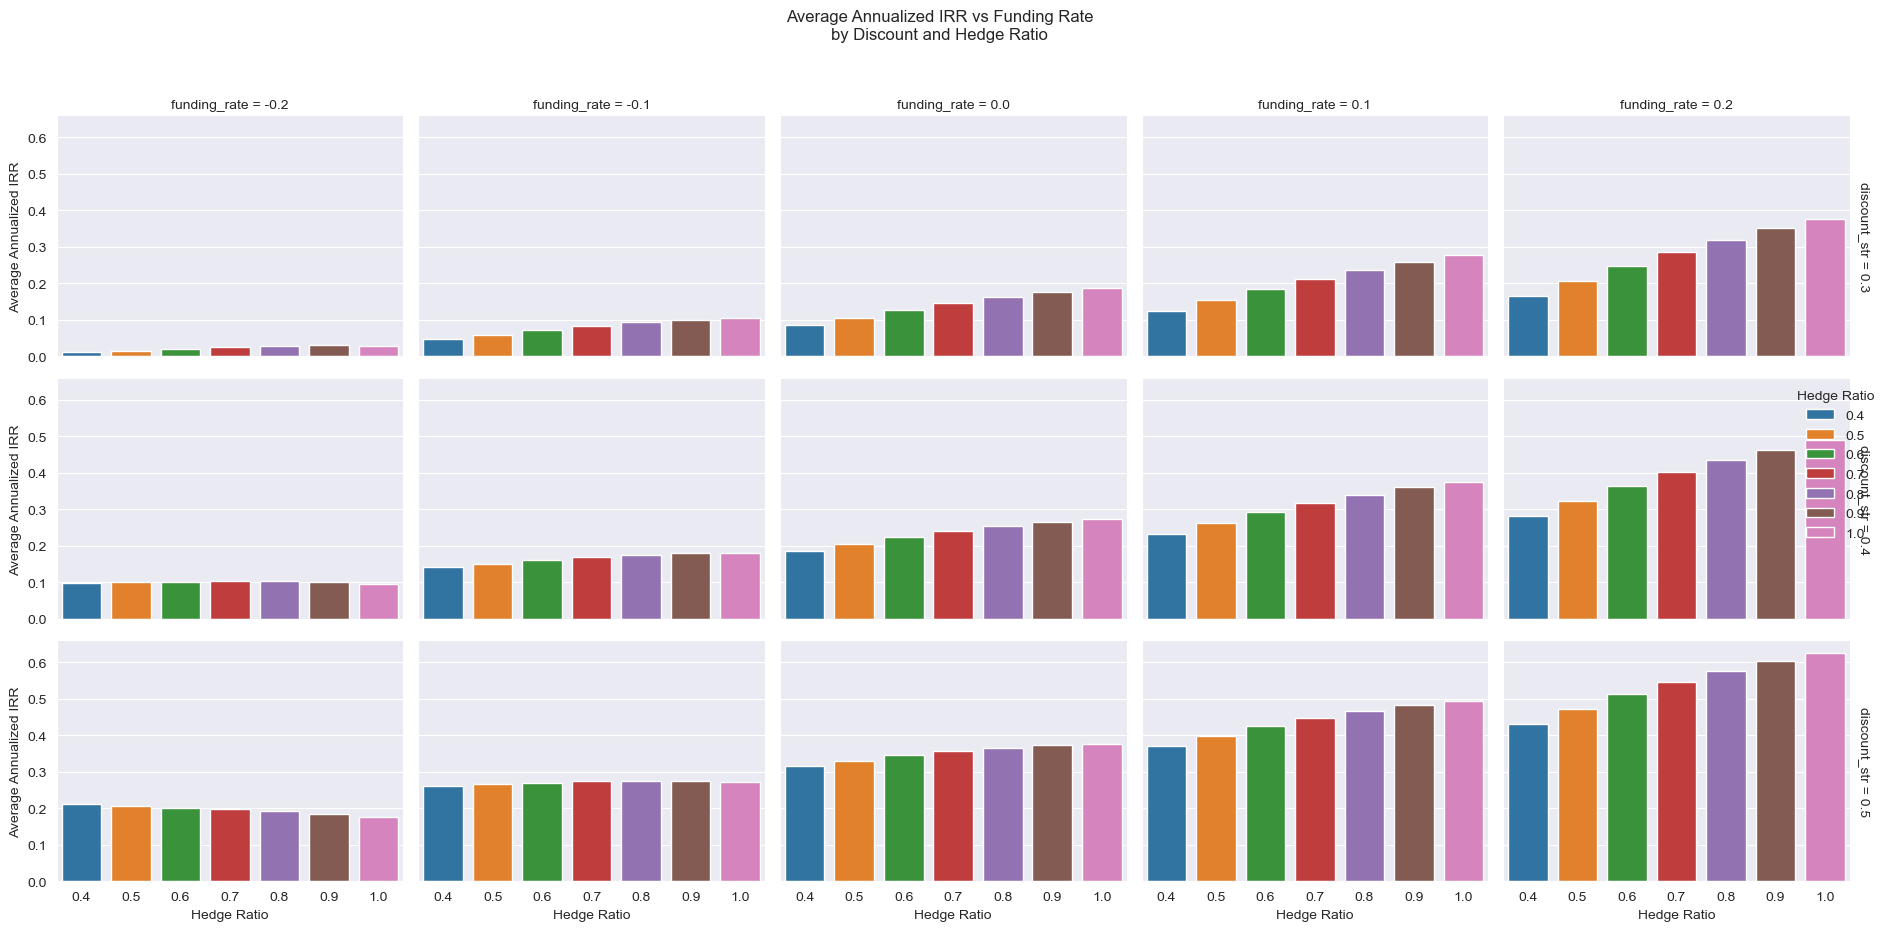

In [140]:
# Ensure discount, hedge_ratio, and funding_rate are available.
results_df['discount_str'] = results_df['discount'].astype(str)
results_df['hedge_ratio_str'] = results_df['hedge_ratio'].astype(str)
results_df['funding_rate'] = pd.to_numeric(results_df['funding_rate'], errors='coerce')

# Create a FacetGrid: each row for a discount, and each column for a funding rate.
g = sns.FacetGrid(results_df, row="discount_str", col="funding_rate", hue="hedge_ratio_str", height=3, aspect=1.2, margin_titles=True)
g.map(sns.barplot, "hedge_ratio_str", "avg_Annualized_IRR", order=sorted(results_df['hedge_ratio_str'].unique()))
g.add_legend(title="Hedge Ratio")
g.set_axis_labels("Hedge Ratio", "Average Annualized IRR")
g.fig.suptitle("Average Annualized IRR vs Funding Rate\nby Discount and Hedge Ratio", y=1.03)
plt.tight_layout()
plt.show()

/Users/janlandfeld/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/lp/f66_8vs504jdlg7rhzhlzn340000gp/T/ipykernel_36277/4033198836.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


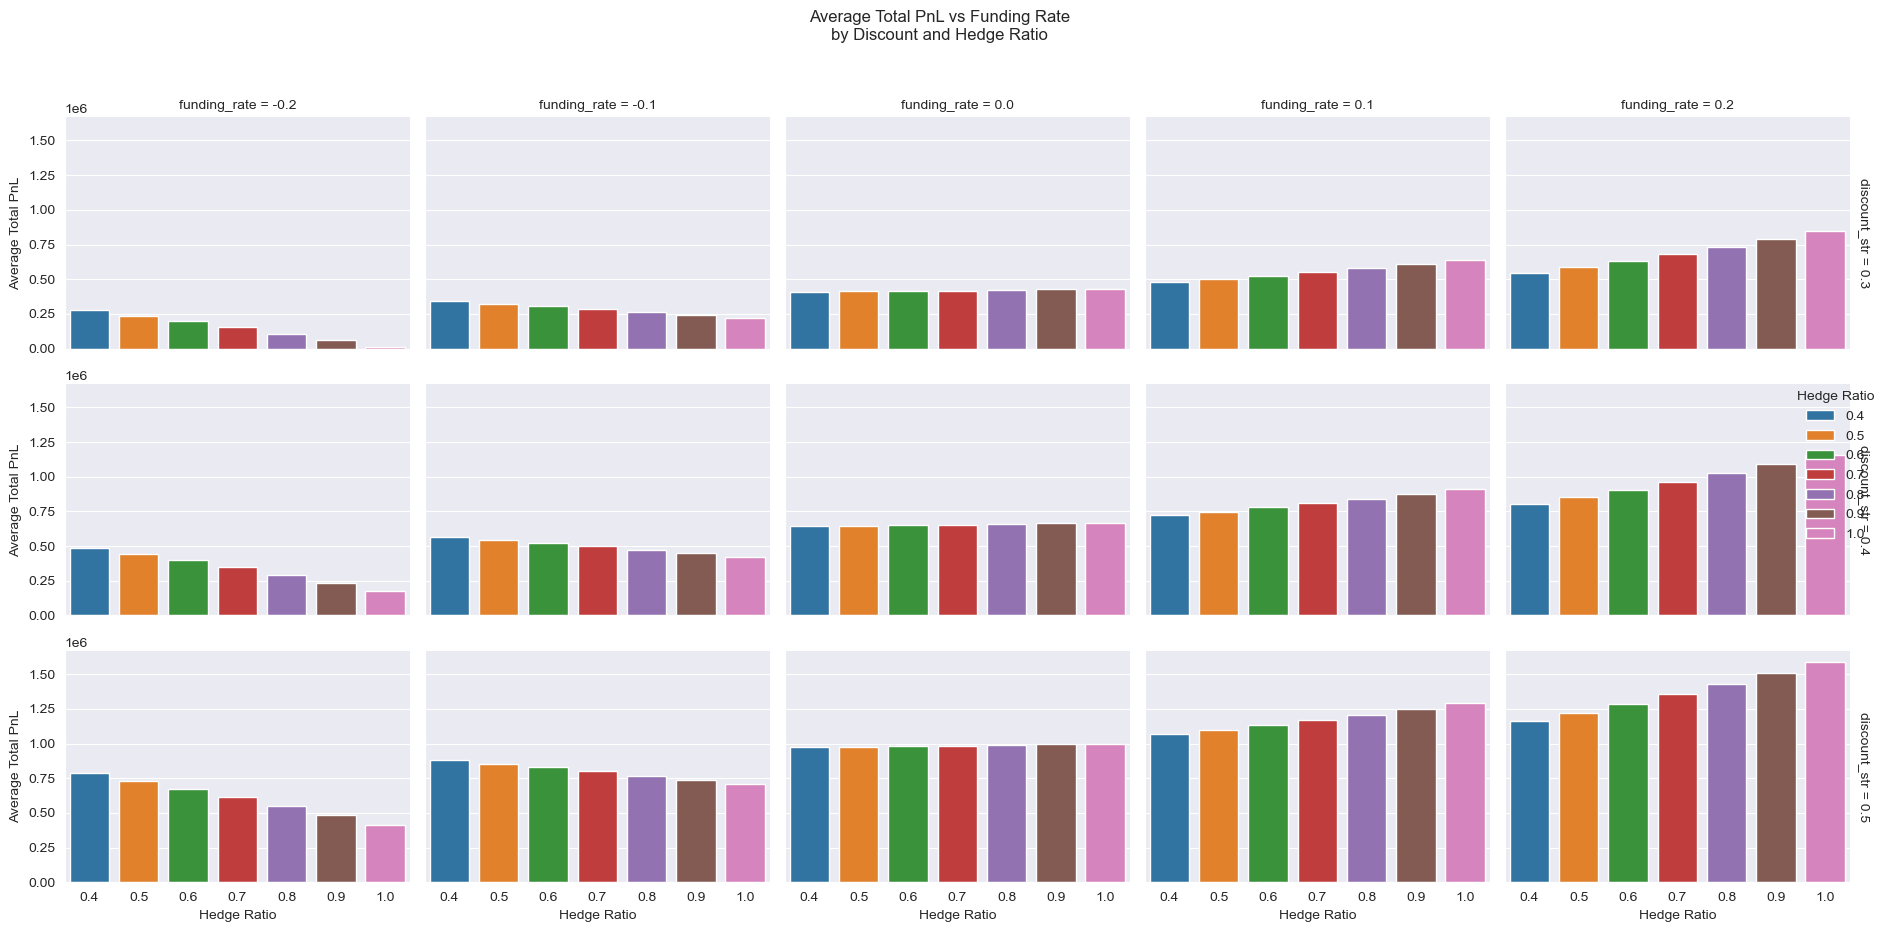

In [158]:
g2 = sns.FacetGrid(
    results_df,
    row="discount_str",
    col="funding_rate",
    hue="hedge_ratio_str",
    height=3,
    aspect=1.2,
    margin_titles=True
)
g2.map_dataframe(
    sns.barplot,
    x="hedge_ratio_str",
    y="avg_Total_PnL",
    order=sorted(results_df['hedge_ratio_str'].unique())
)
g2.add_legend(title="Hedge Ratio")
g2.set_axis_labels("Hedge Ratio", "Average Total PnL")
g2.fig.suptitle("Average Total PnL vs Funding Rate\nby Discount and Hedge Ratio", y=1.03)
plt.tight_layout()
plt.show()


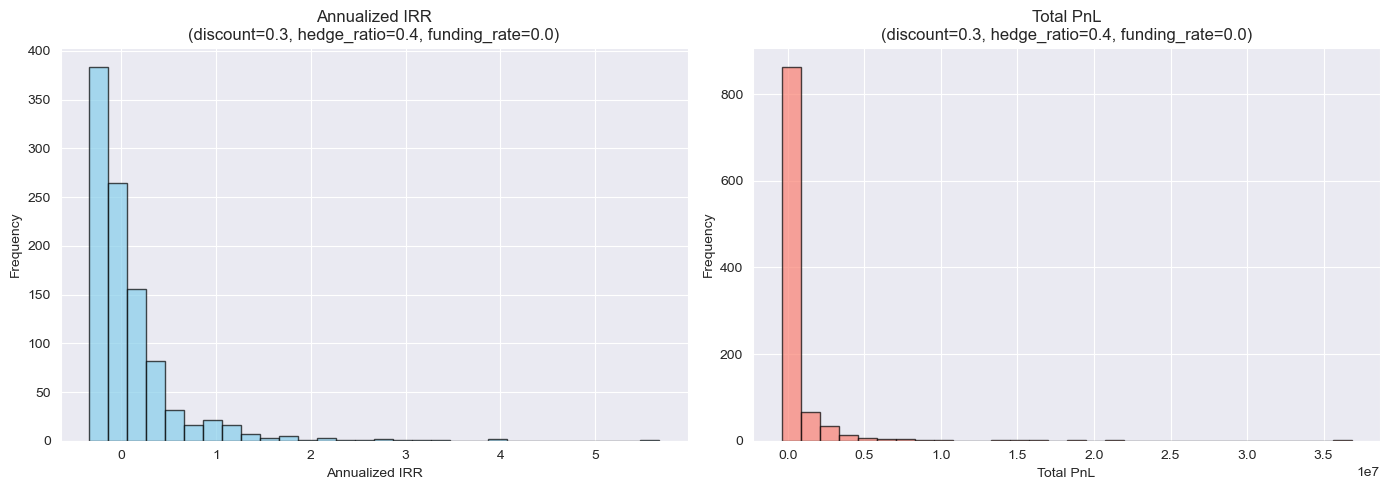

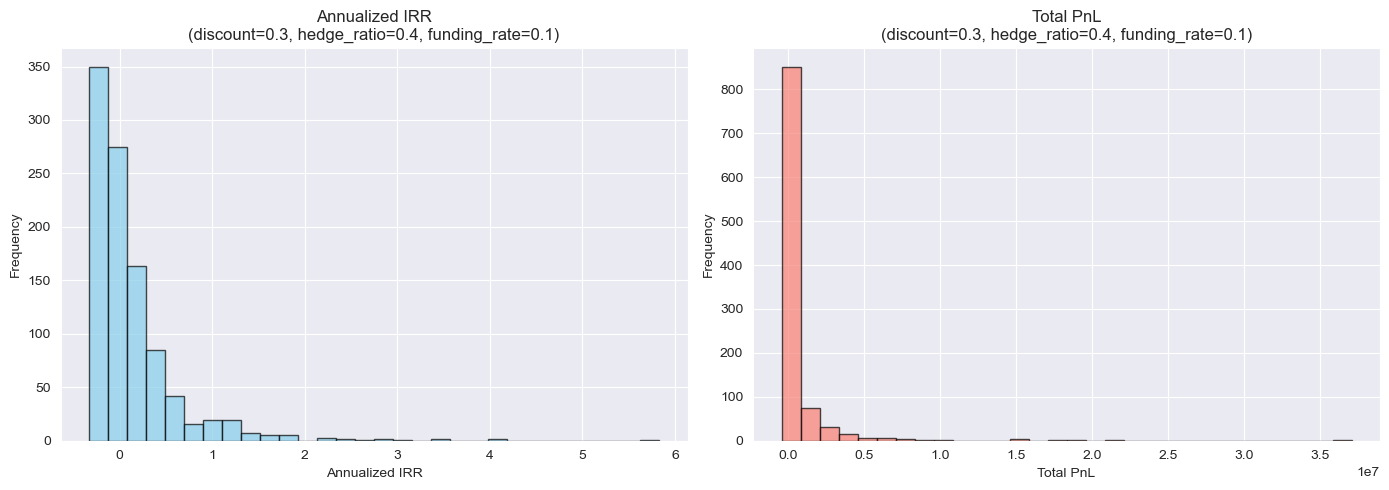

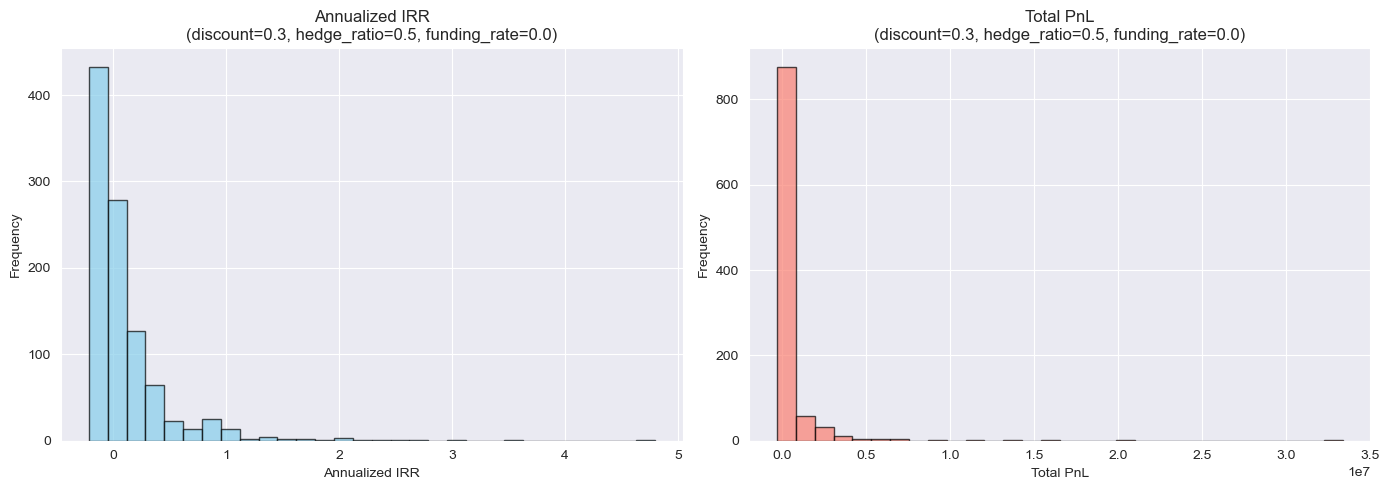

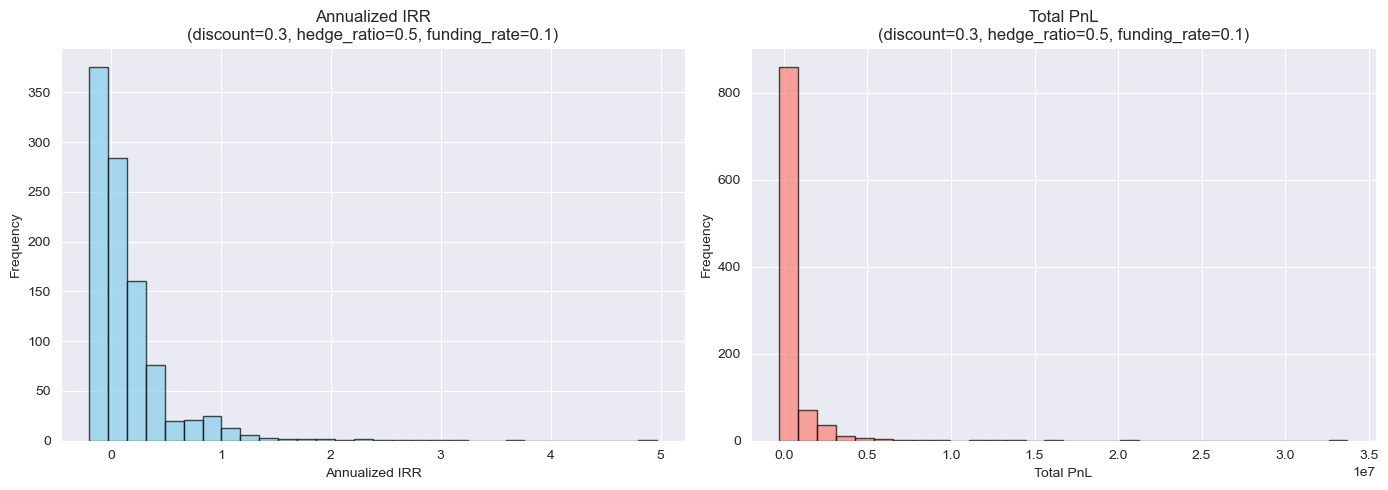

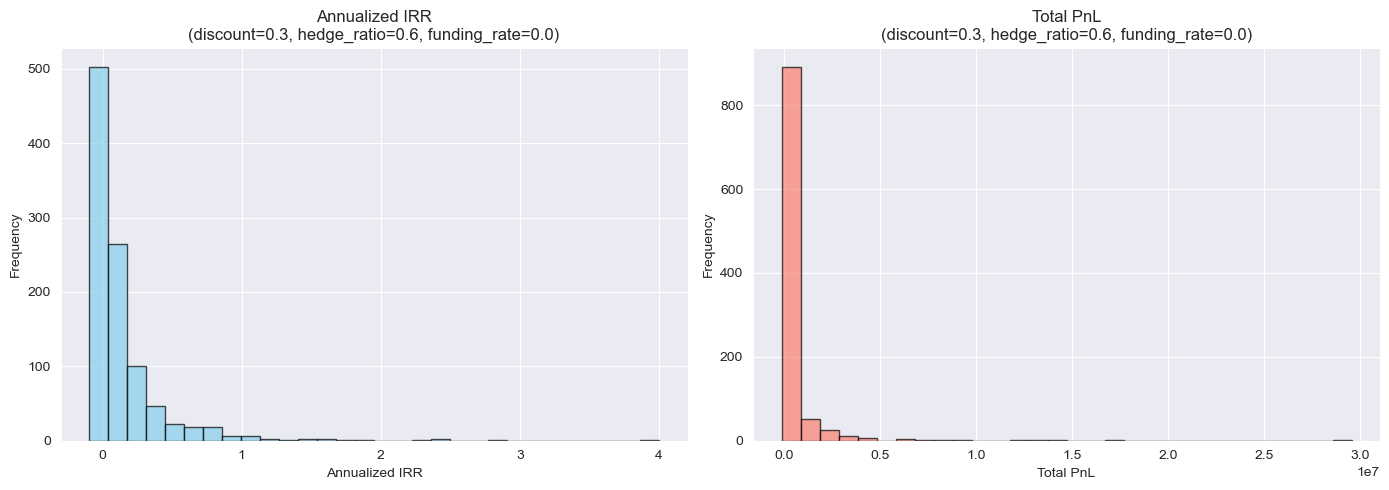

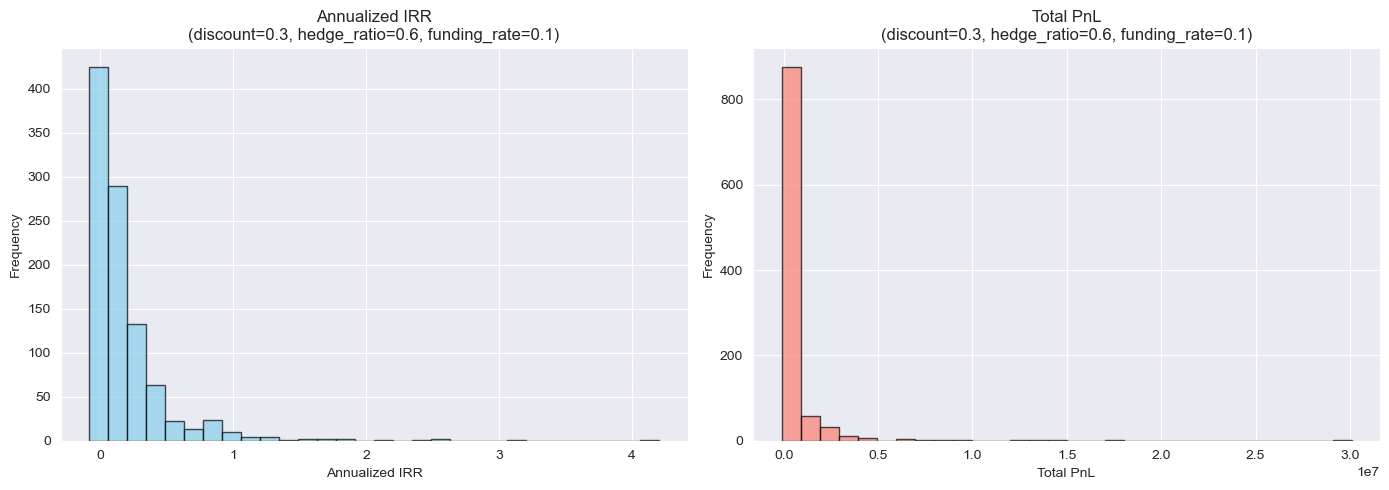

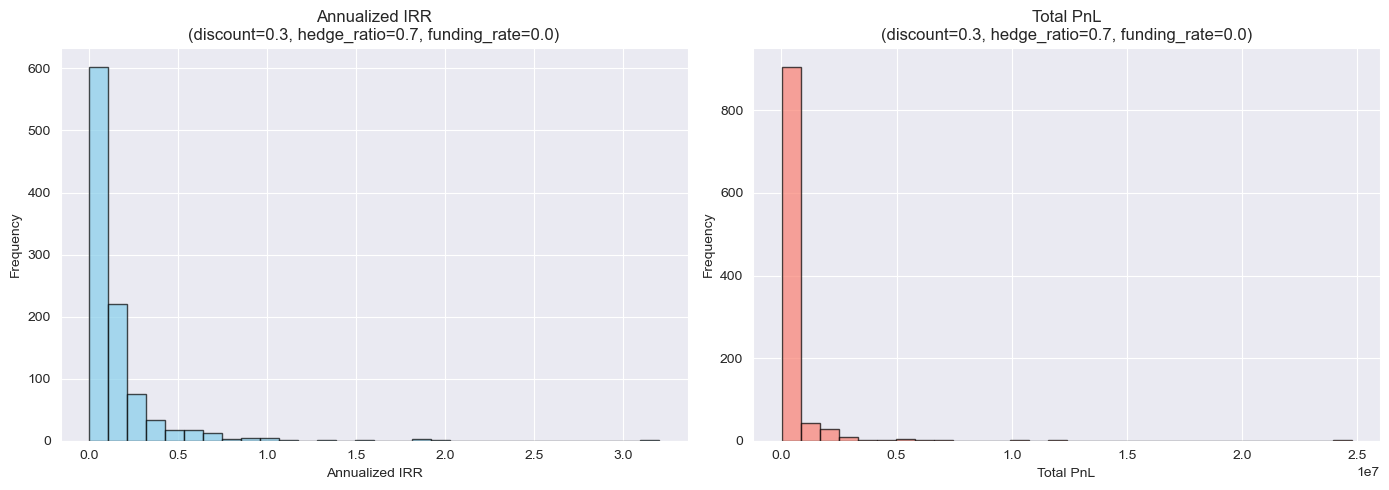

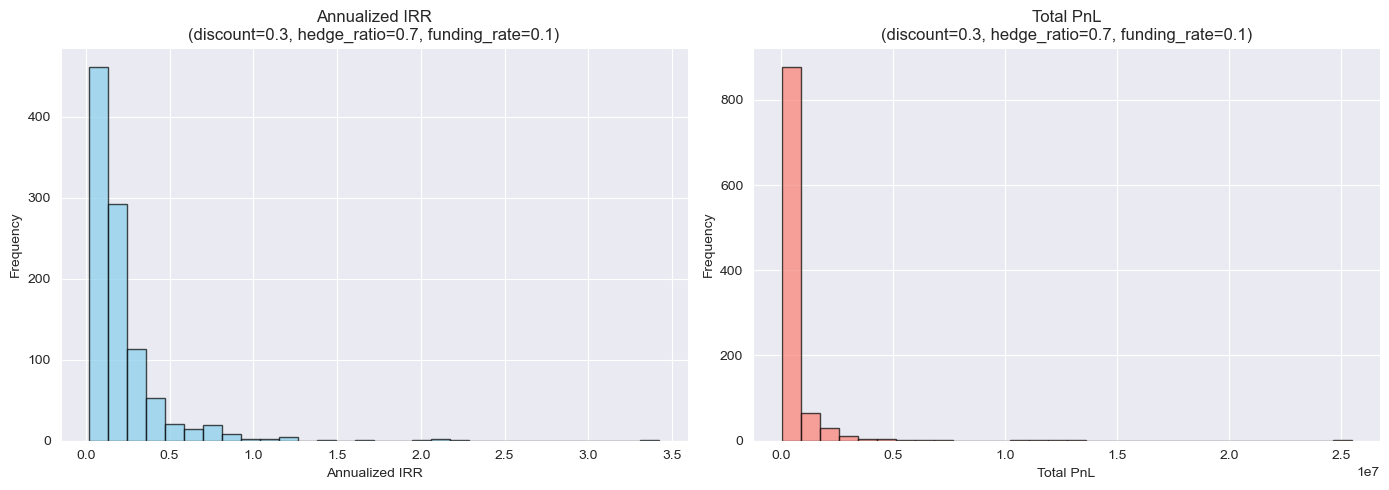

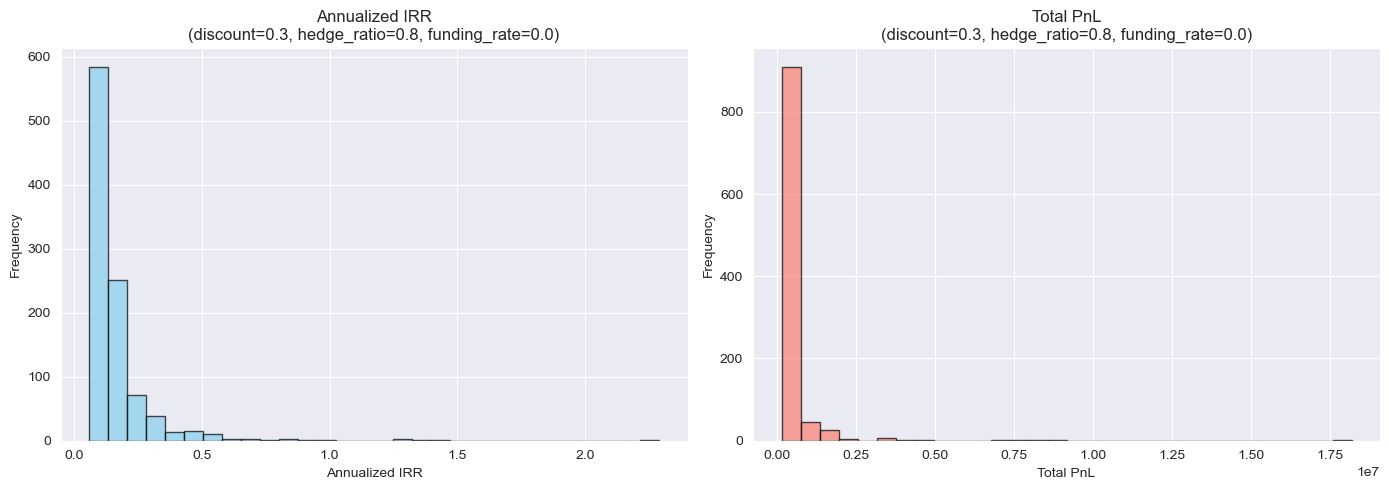

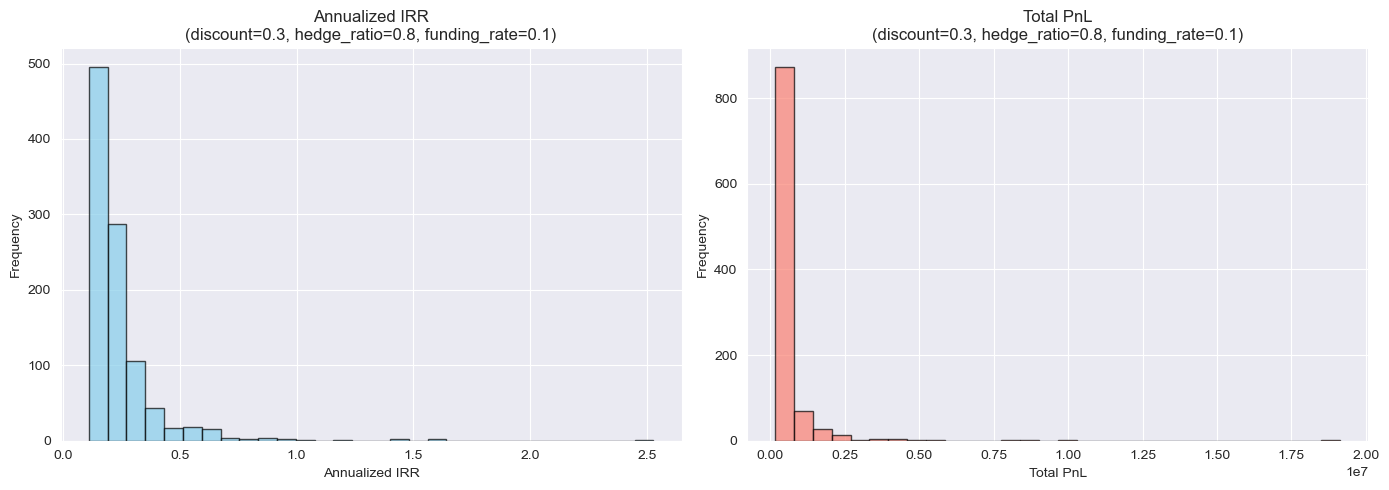

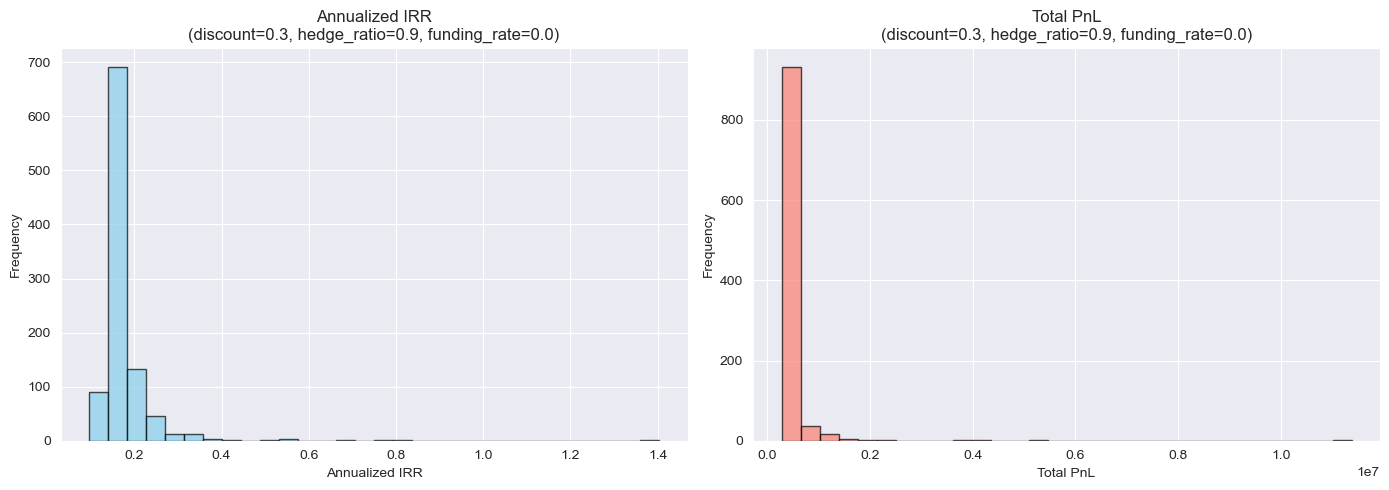

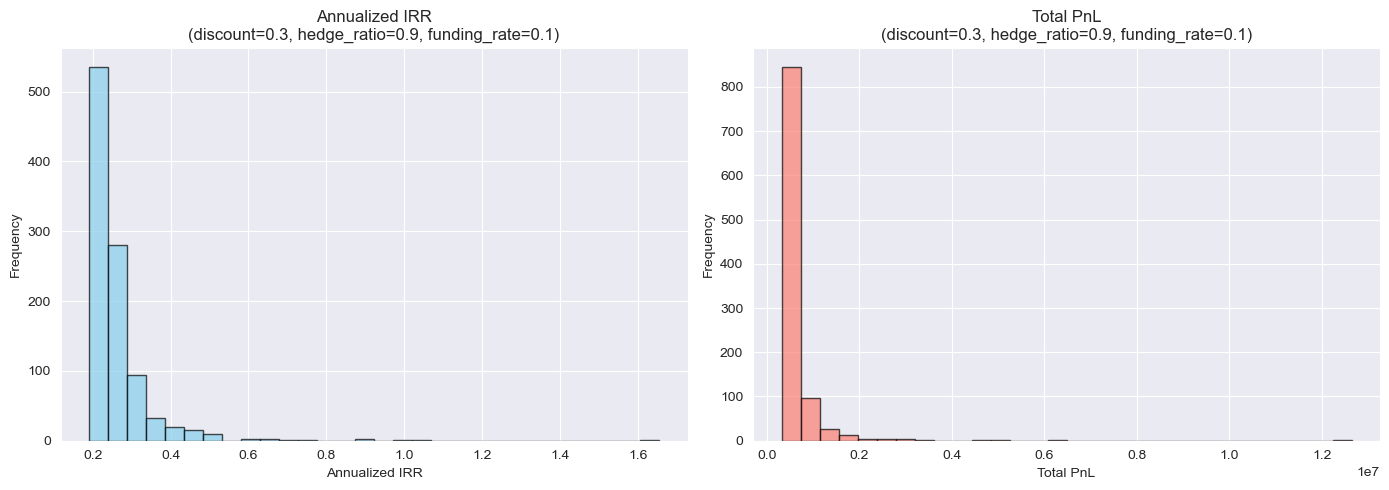

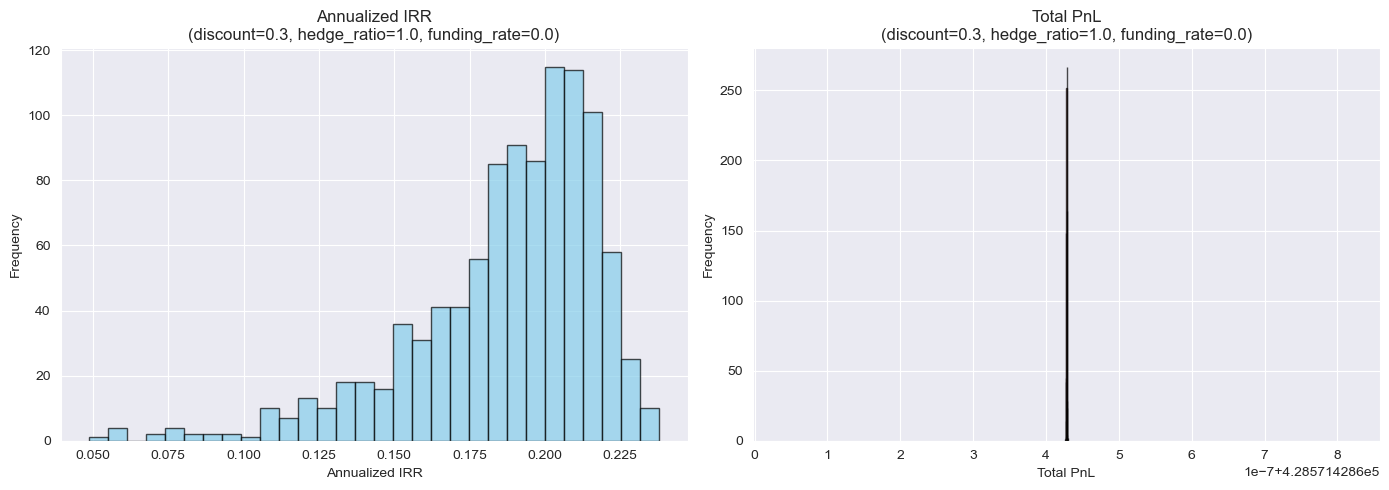

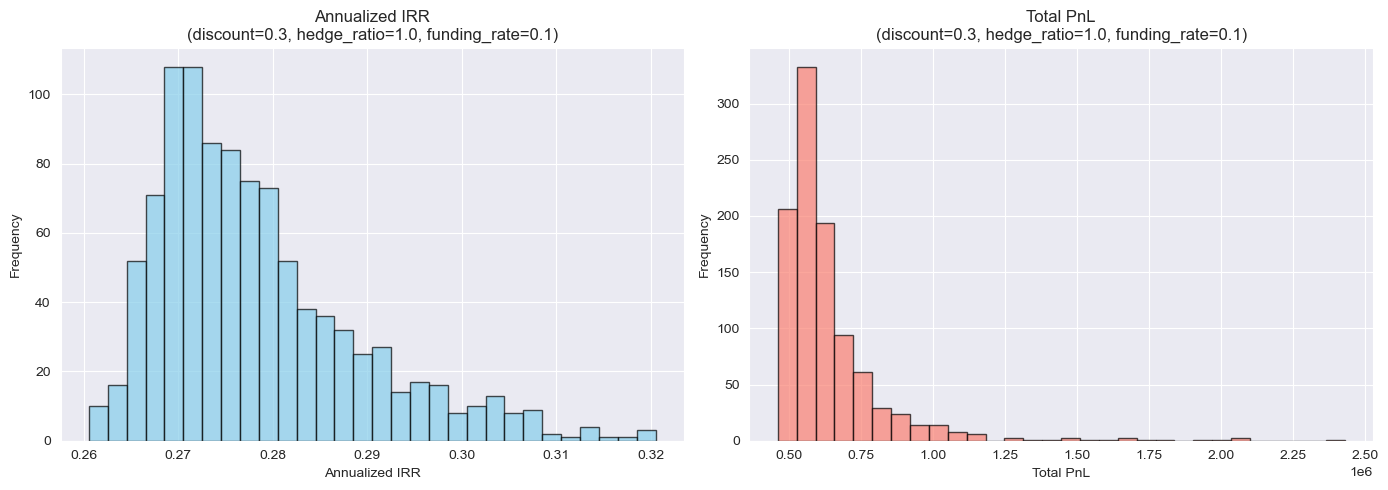

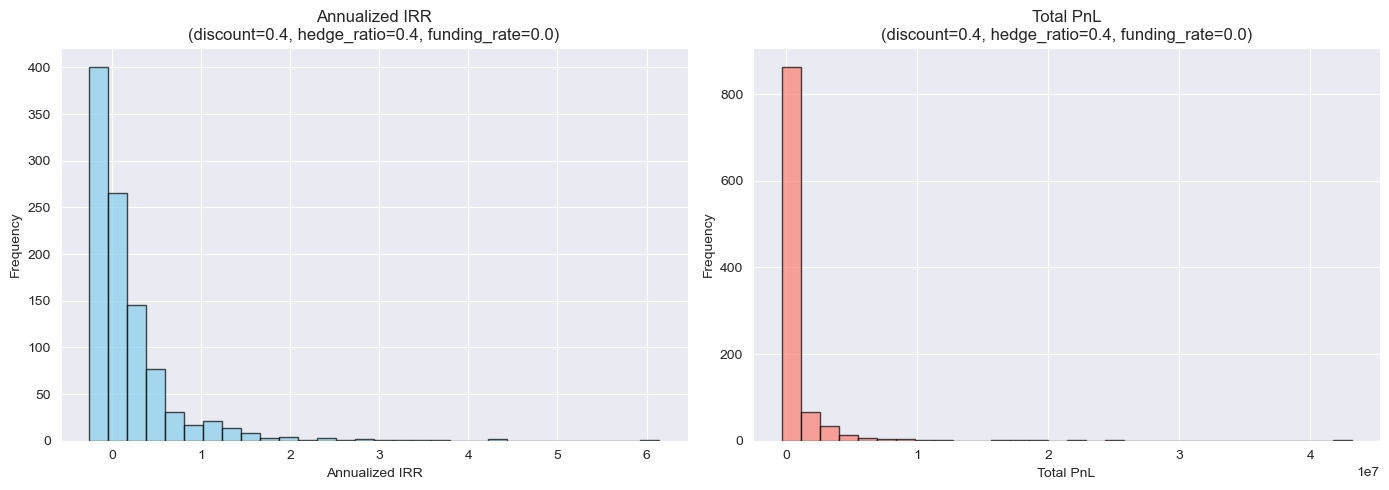

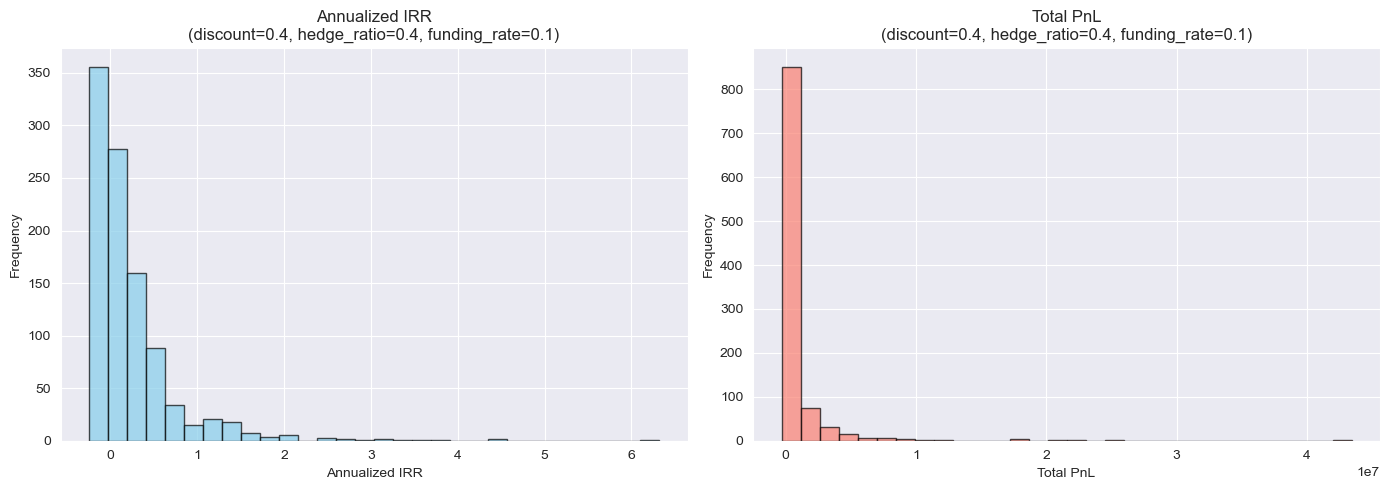

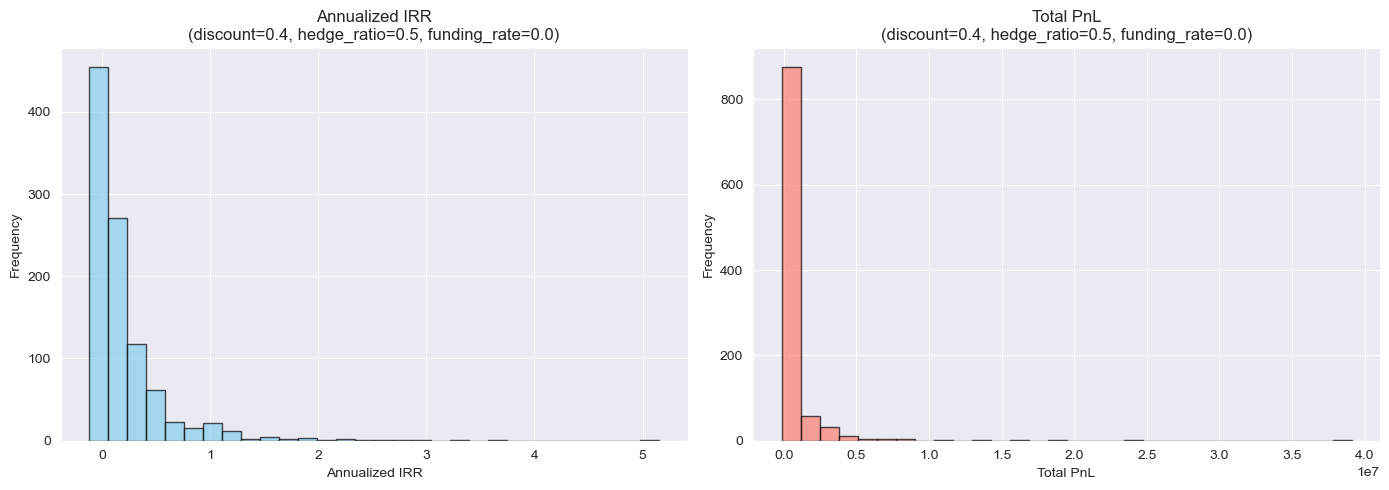

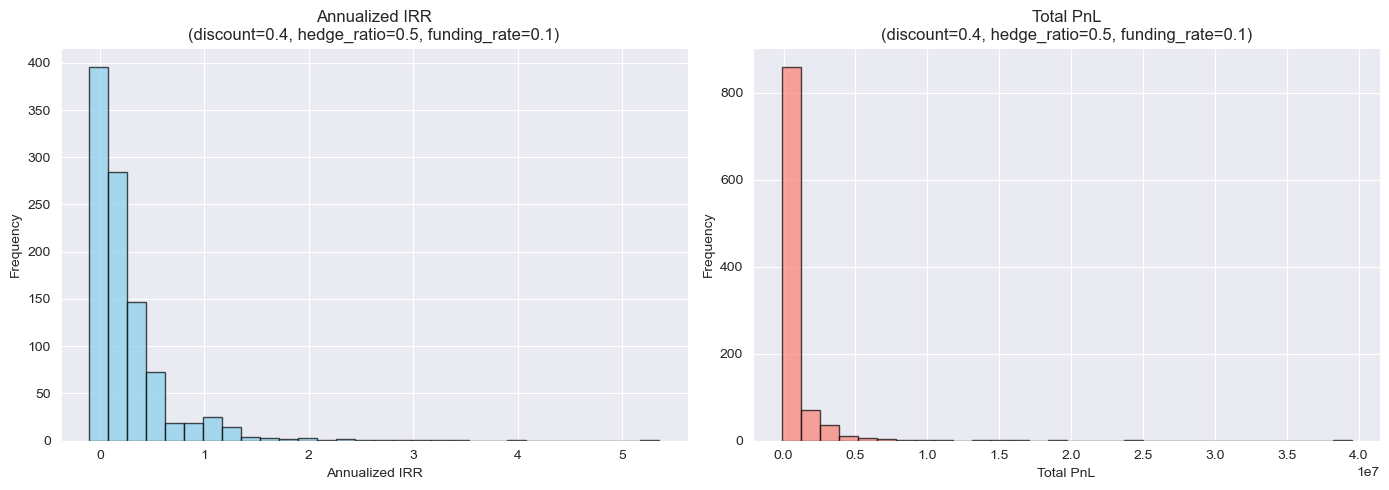

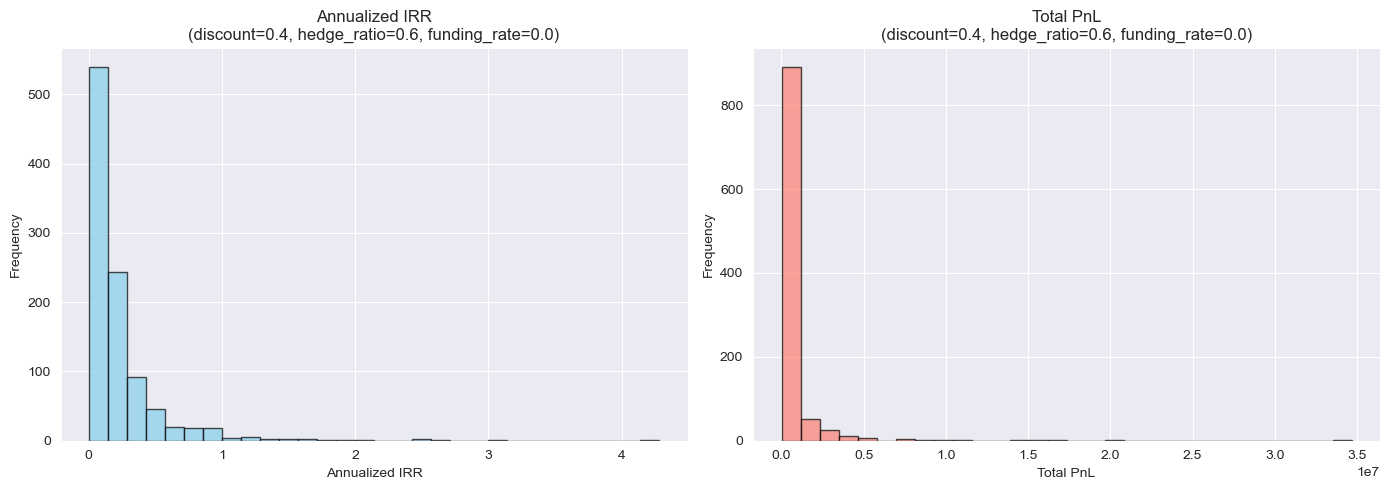

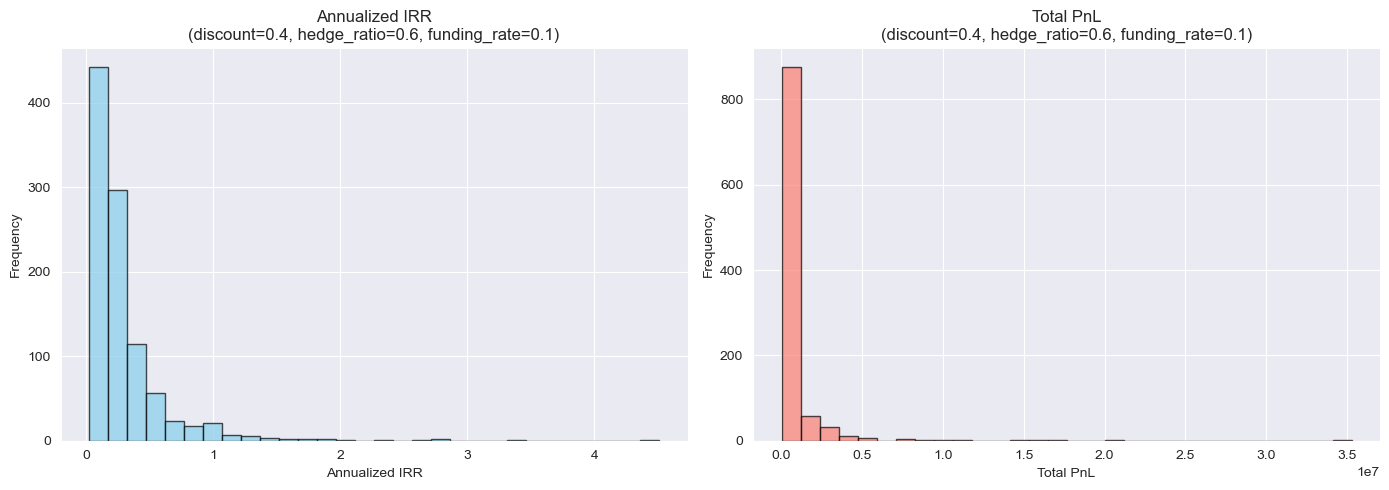

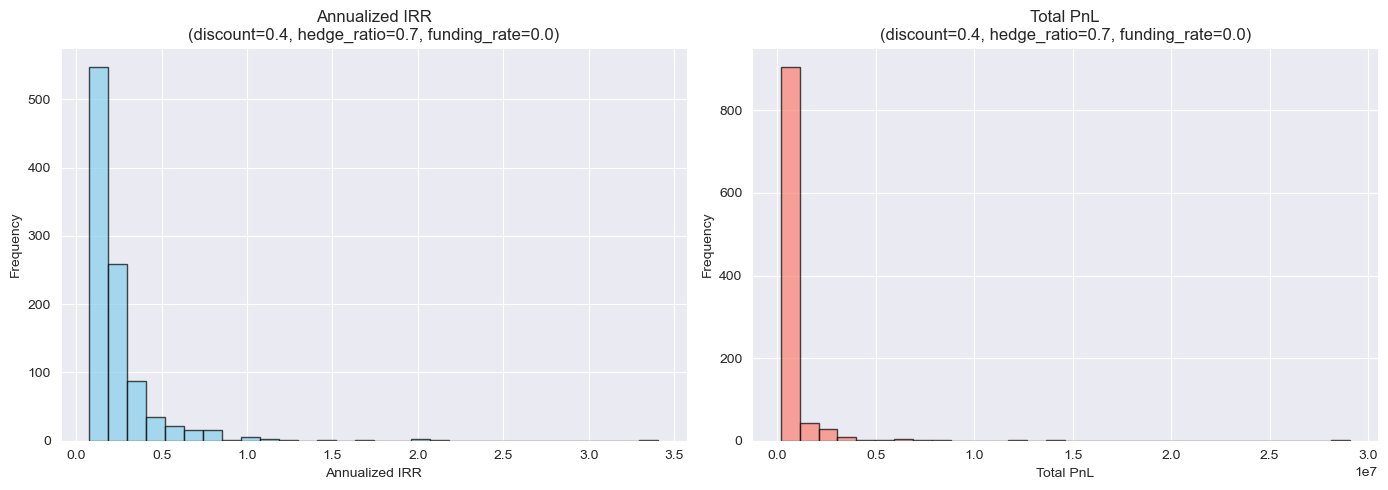

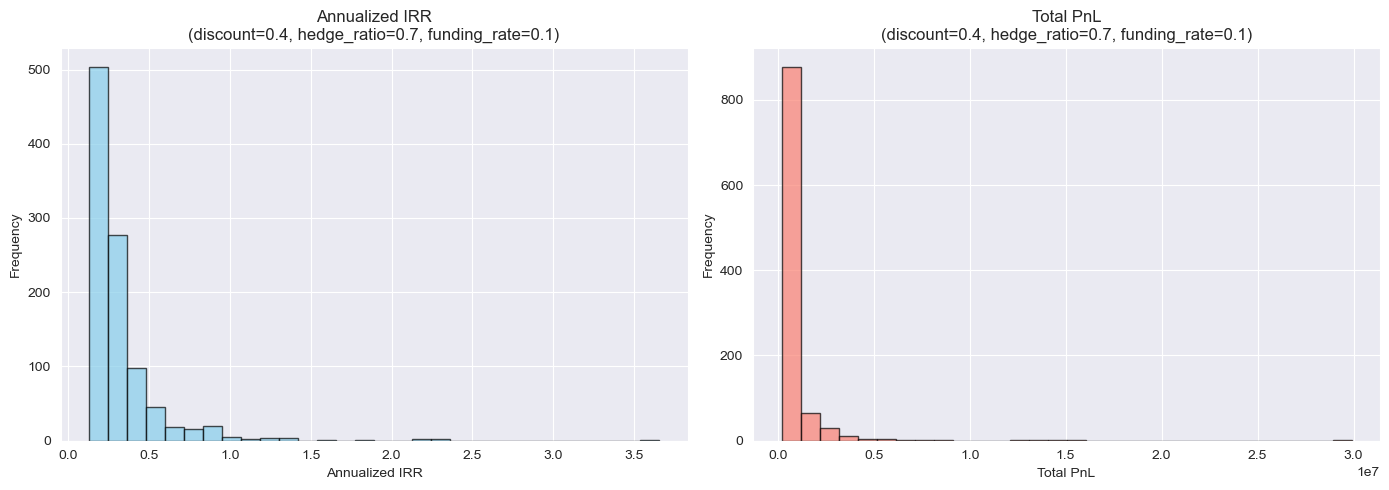

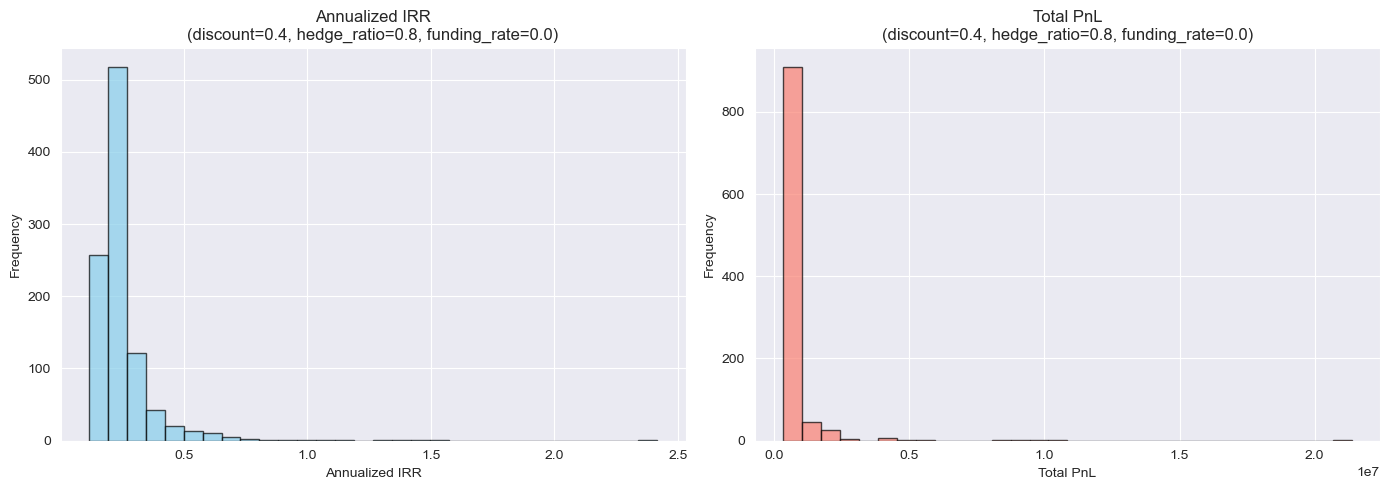

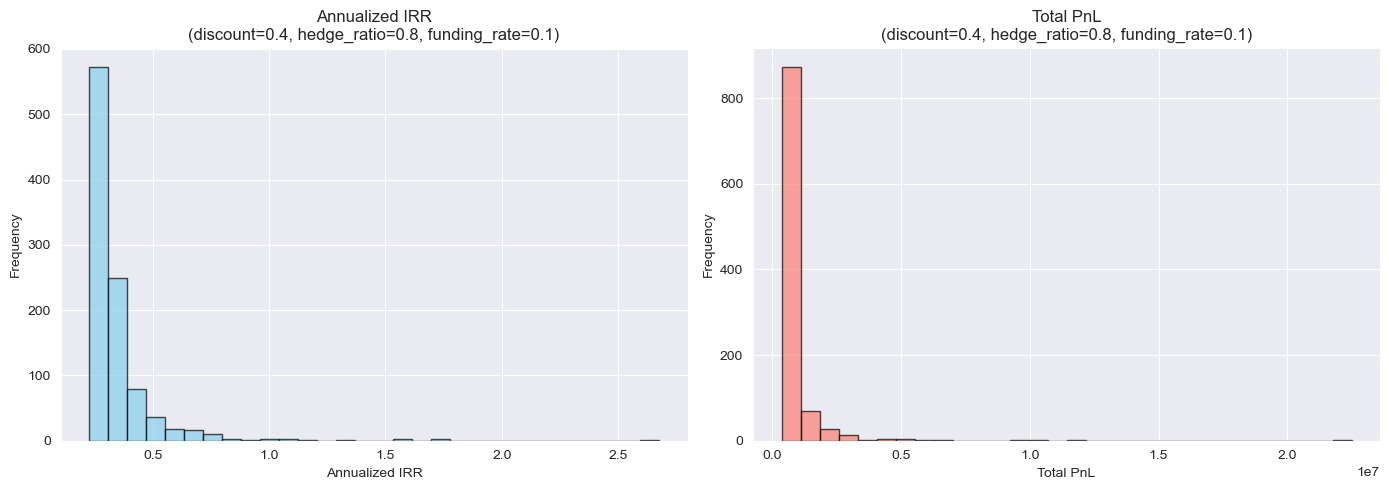

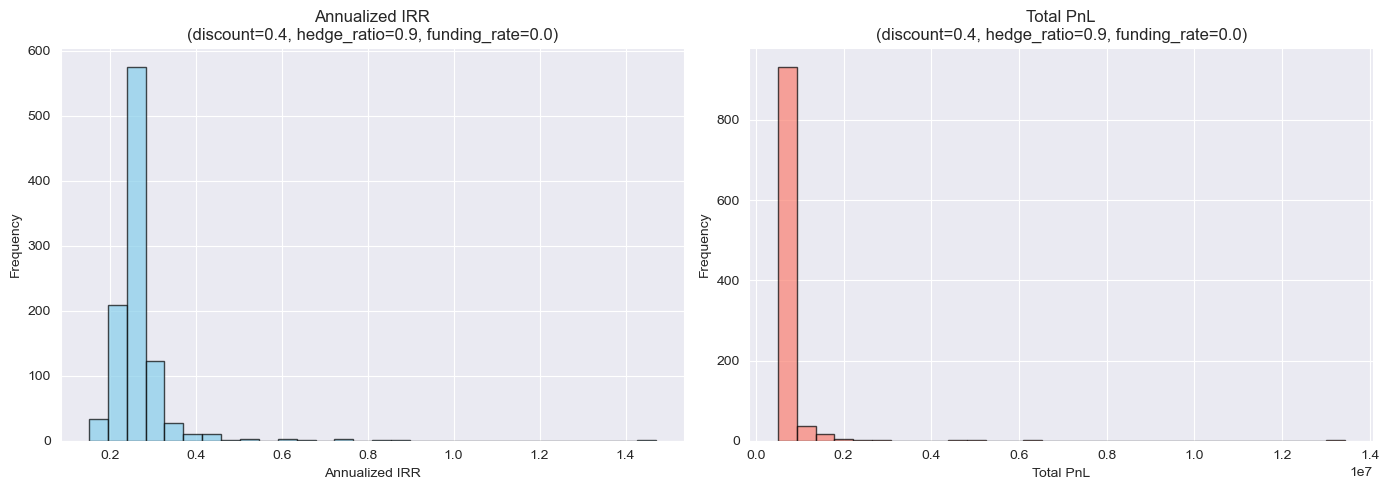

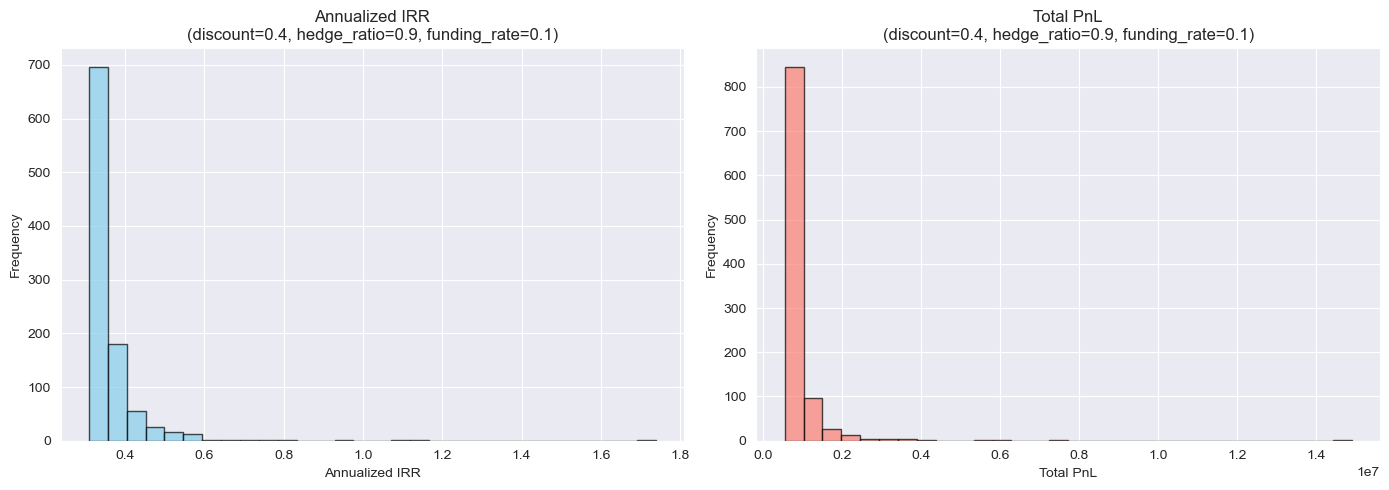

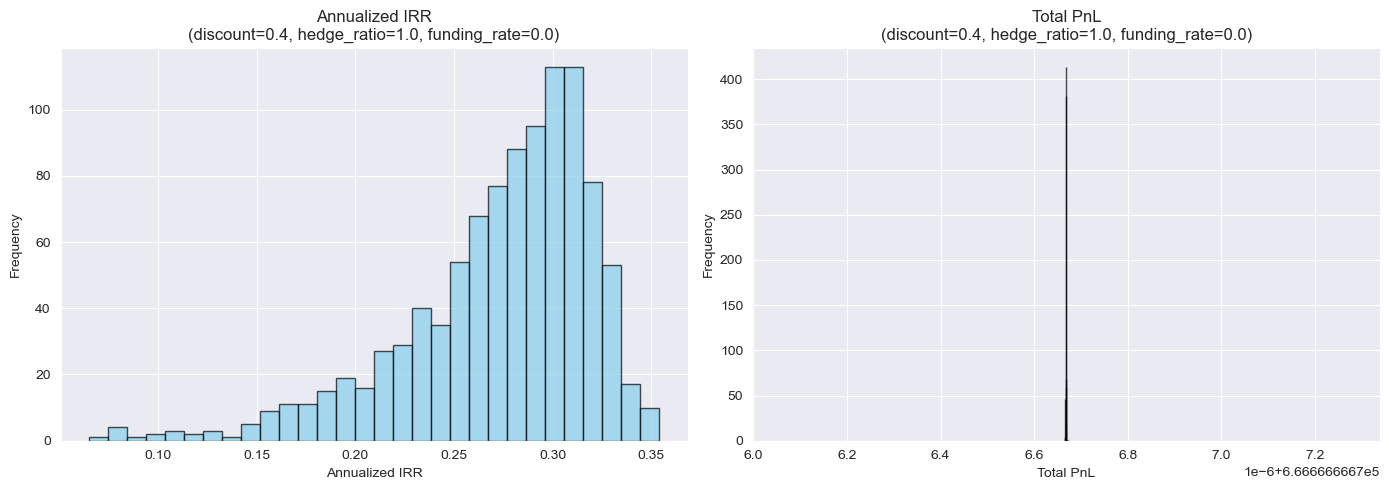

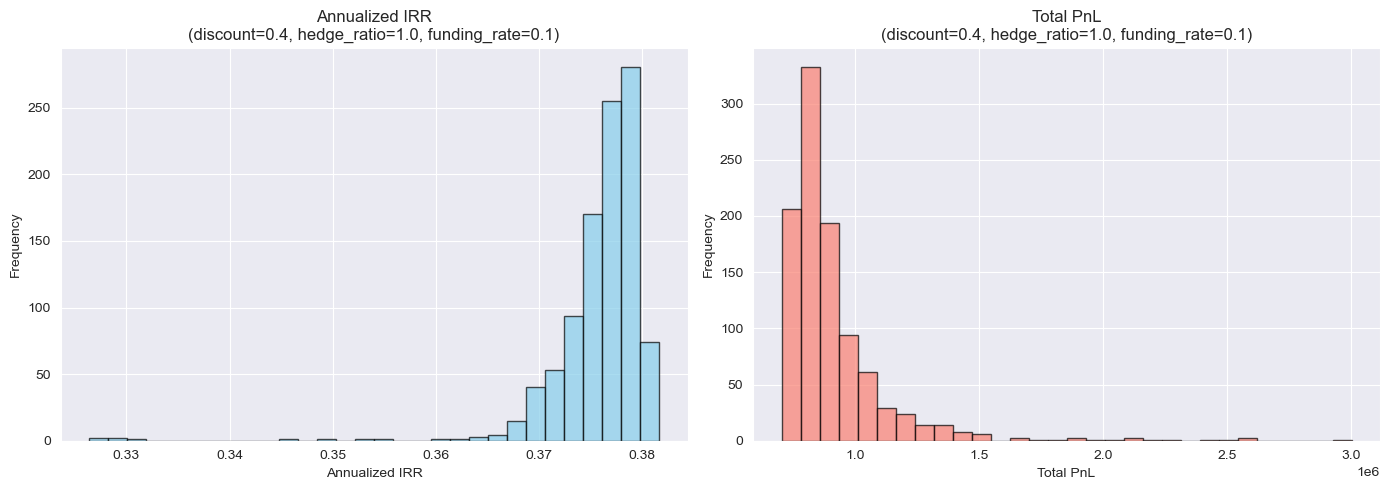

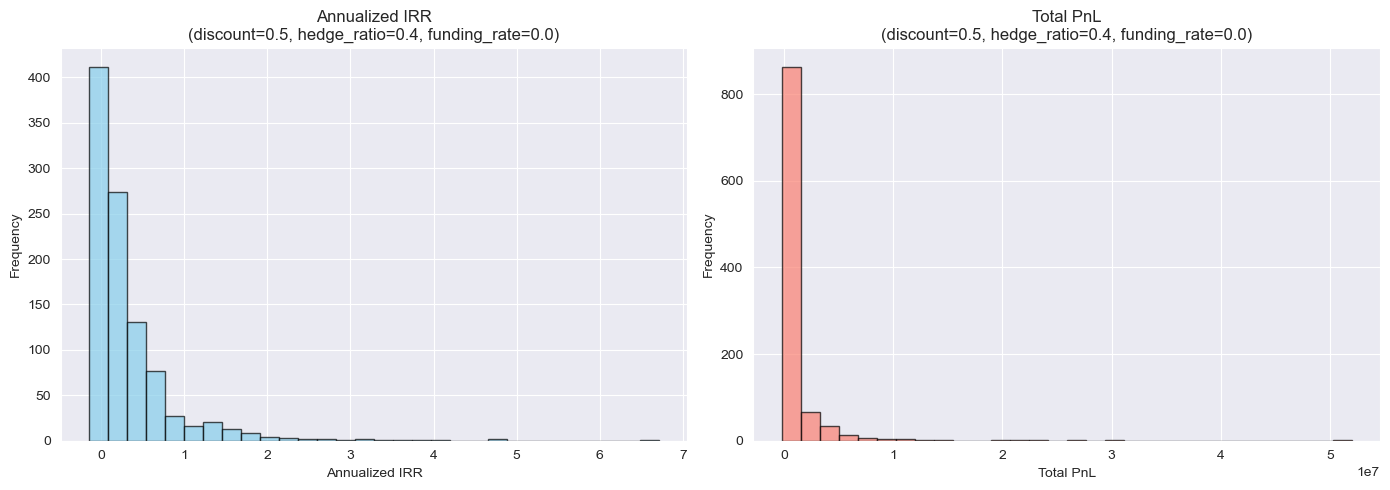

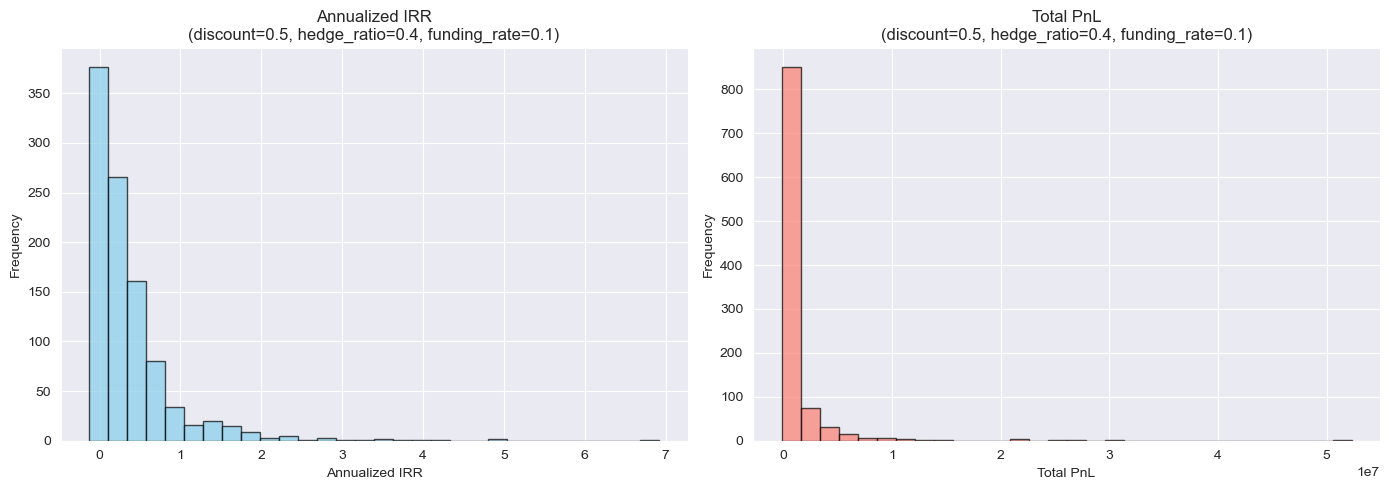

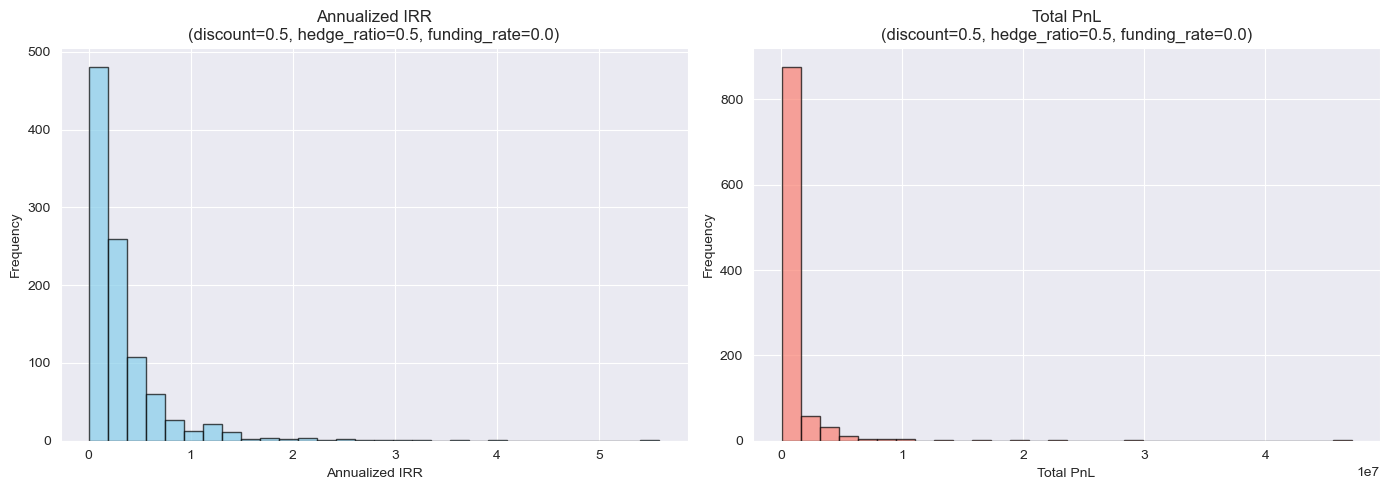

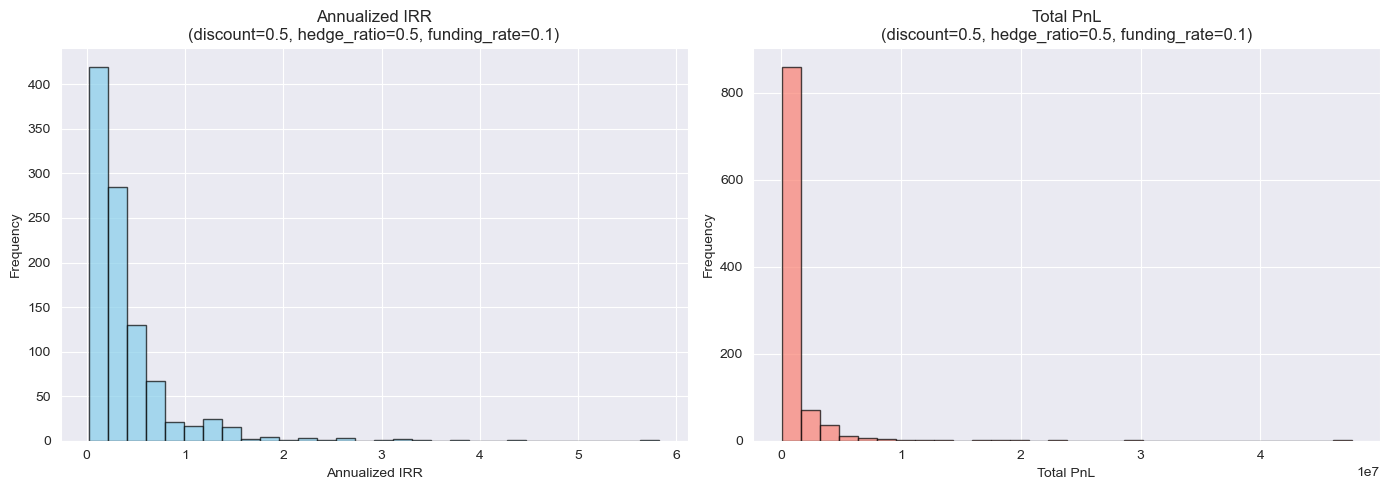

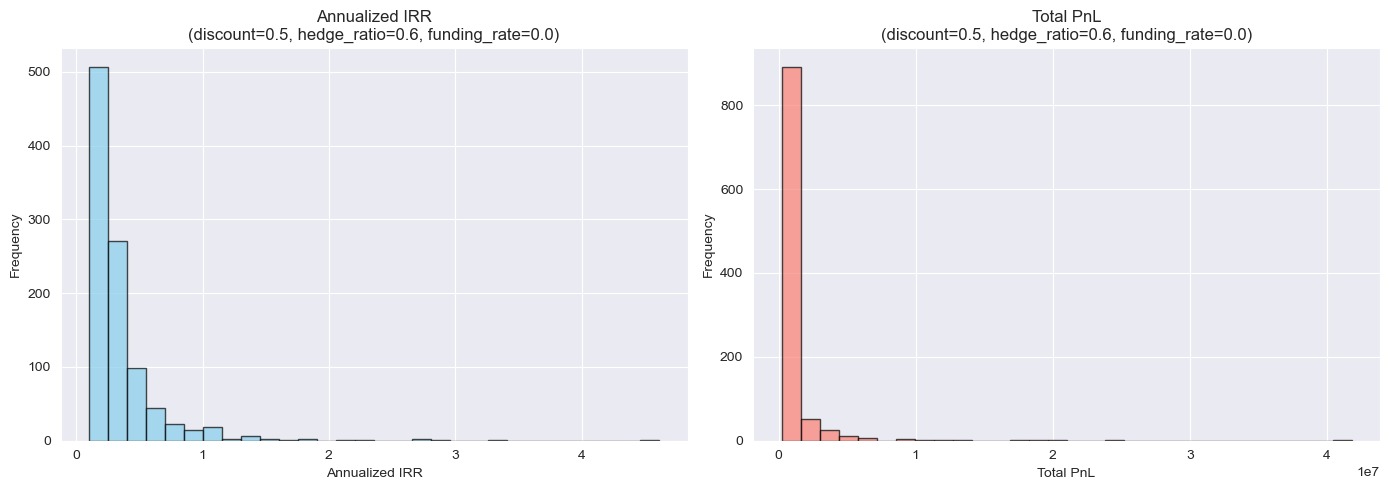

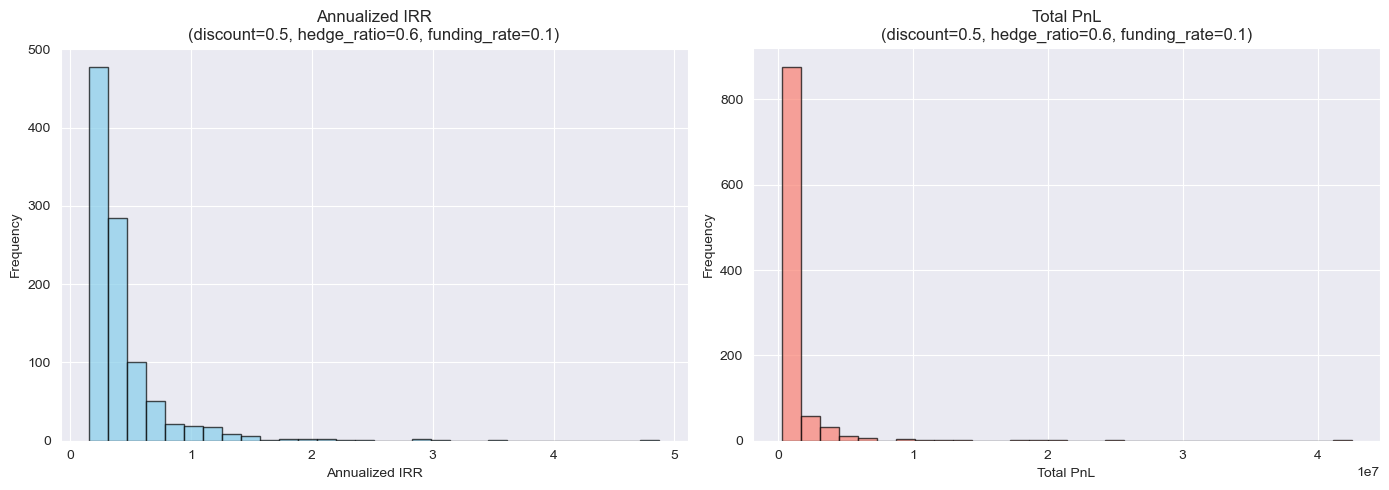

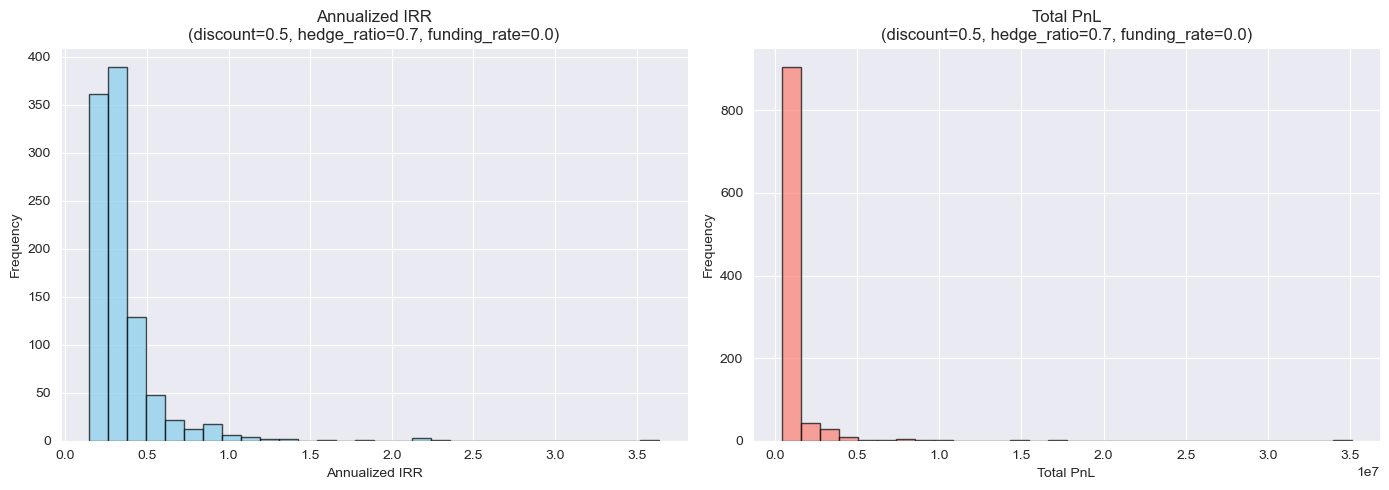

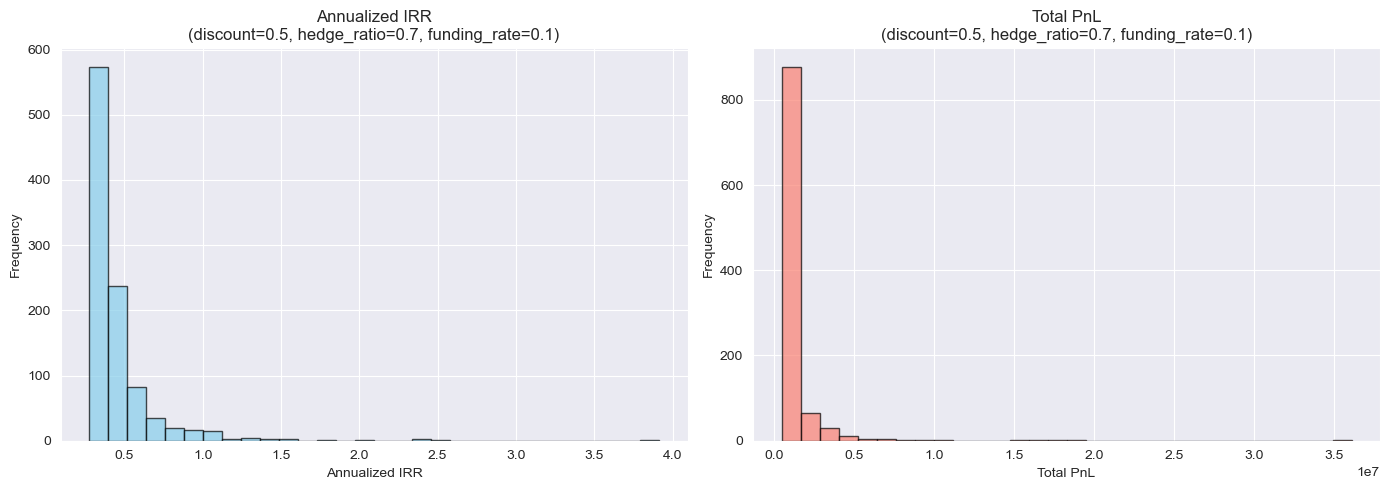

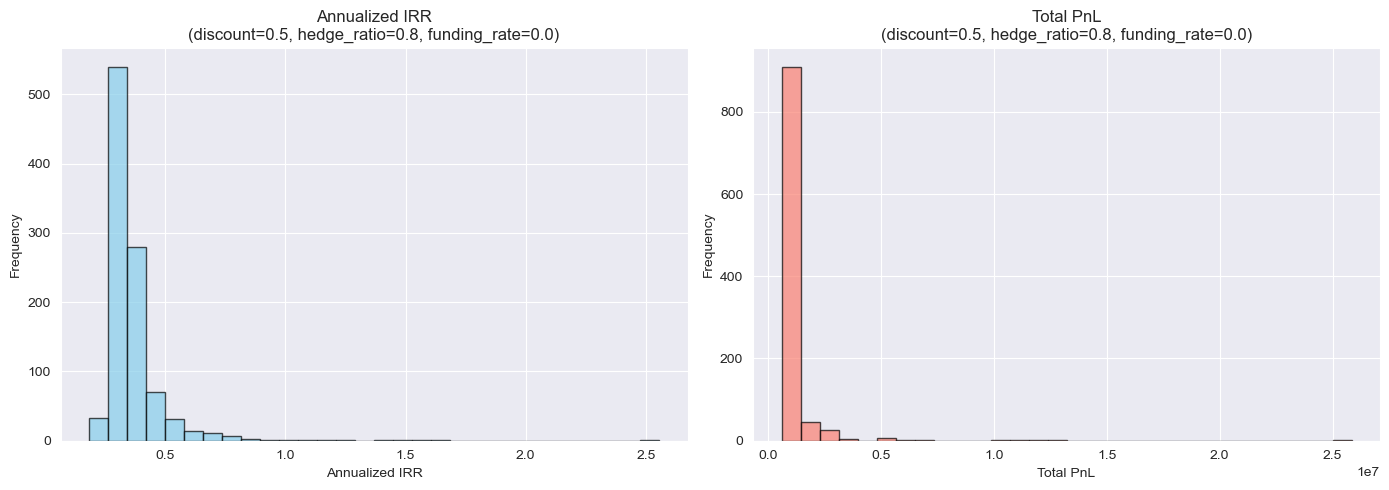

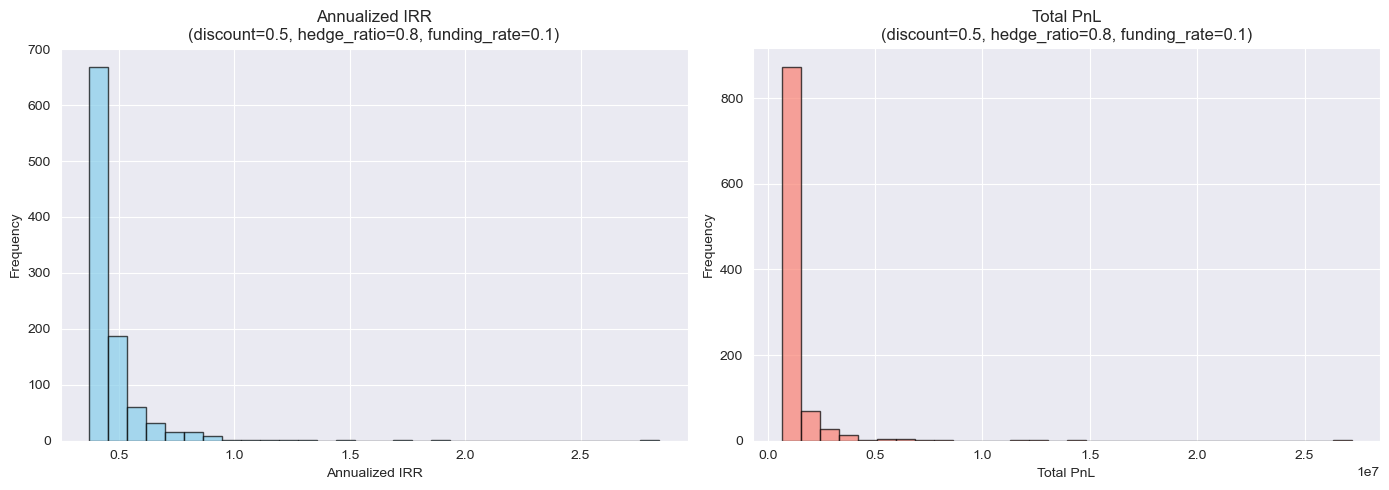

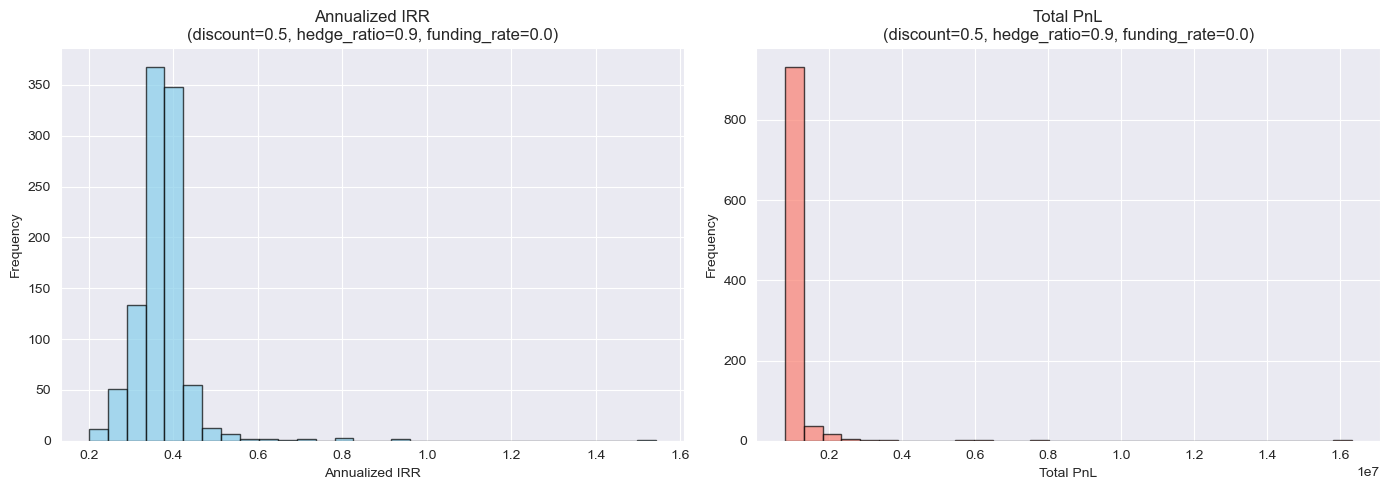

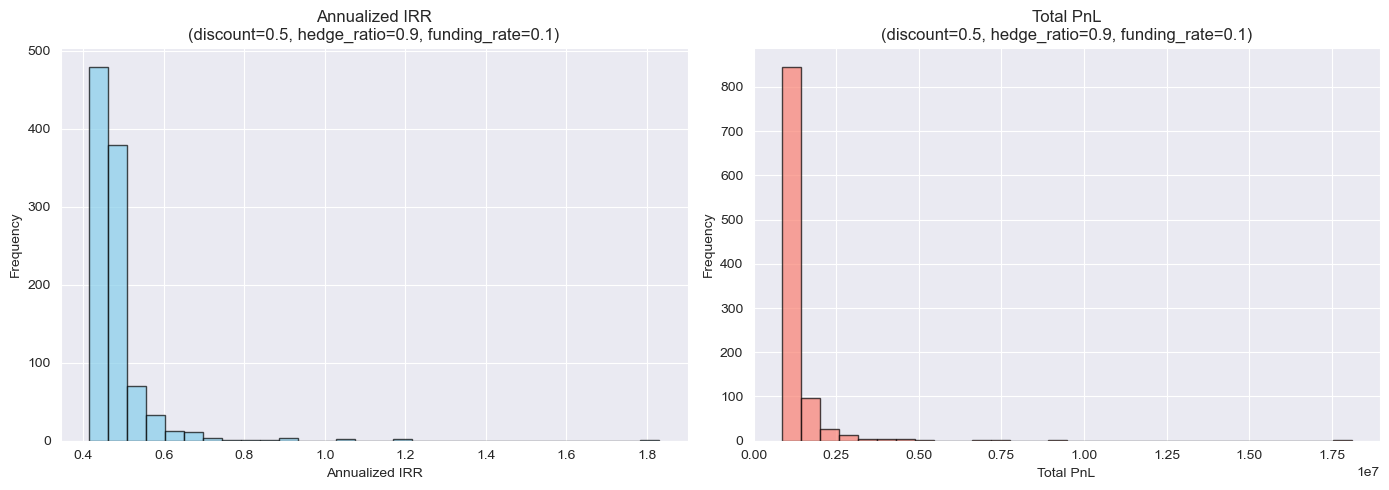

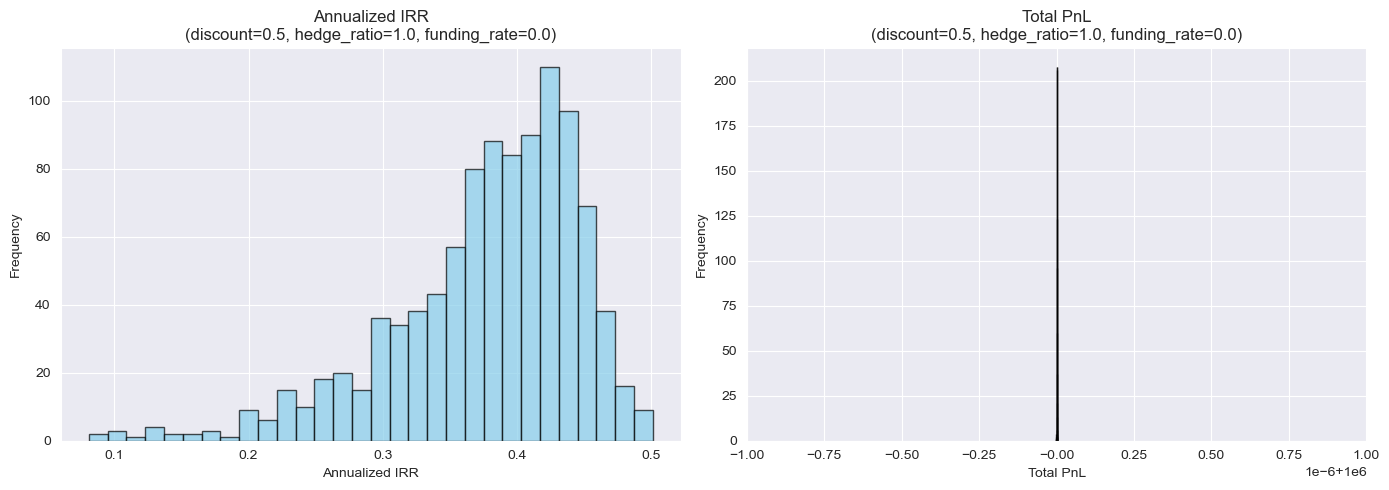

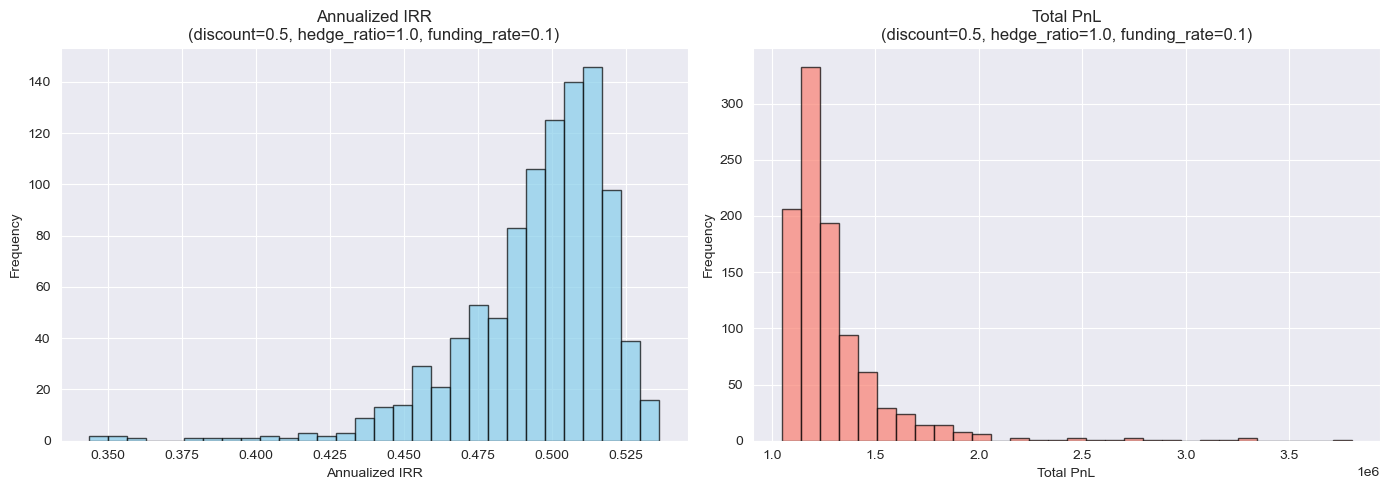

In [160]:
# Create histograms for each combination of parameters
for key in sorted(detailed_ann_irr.keys()):
    disc, hedg, fund = key
    
    # Only plot if the funding rate is 0.1 or 0.0
    if fund in [0.1, 0.0]:
        ann_irr_values = detailed_ann_irr[key]
        pnl_values = detailed_pnl[key]
        
        # Create a figure with two subplots: one for Annualized IRR and one for Total PnL
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot histogram for Annualized IRR
        ax1.hist(ann_irr_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel("Annualized IRR")
        ax1.set_ylabel("Frequency")
        ax1.set_title(f"Annualized IRR\n(discount={disc}, hedge_ratio={hedg}, funding_rate={fund})")
        ax1.grid(True)
        
        # Plot histogram for Total PnL
        ax2.hist(pnl_values, bins=30, alpha=0.7, color='salmon', edgecolor='black')
        ax2.set_xlabel("Total PnL")
        ax2.set_ylabel("Frequency")
        ax2.set_title(f"Total PnL\n(discount={disc}, hedge_ratio={hedg}, funding_rate={fund})")
        ax2.grid(True)
        
        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()

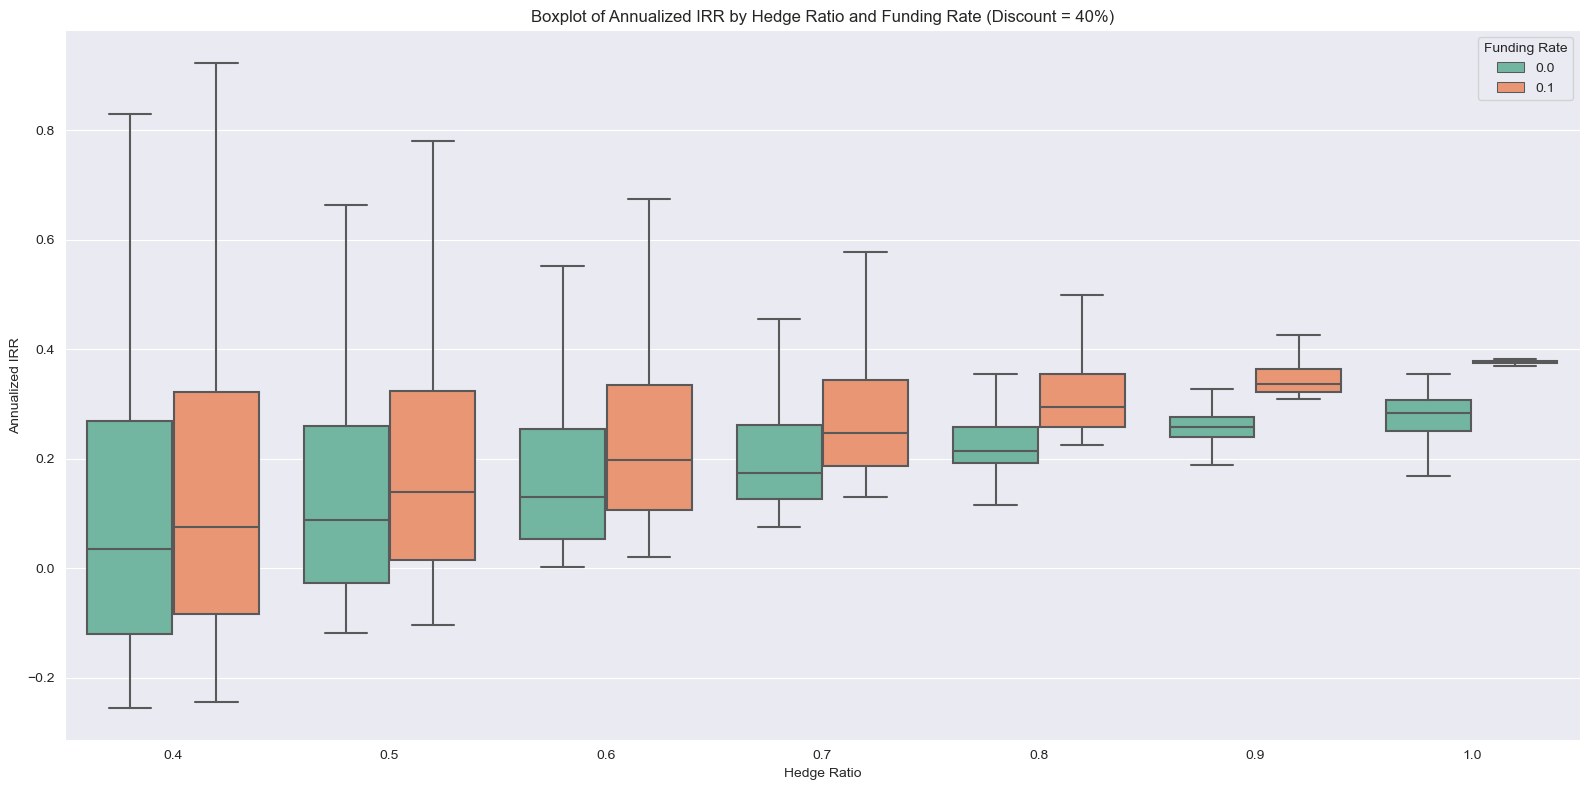

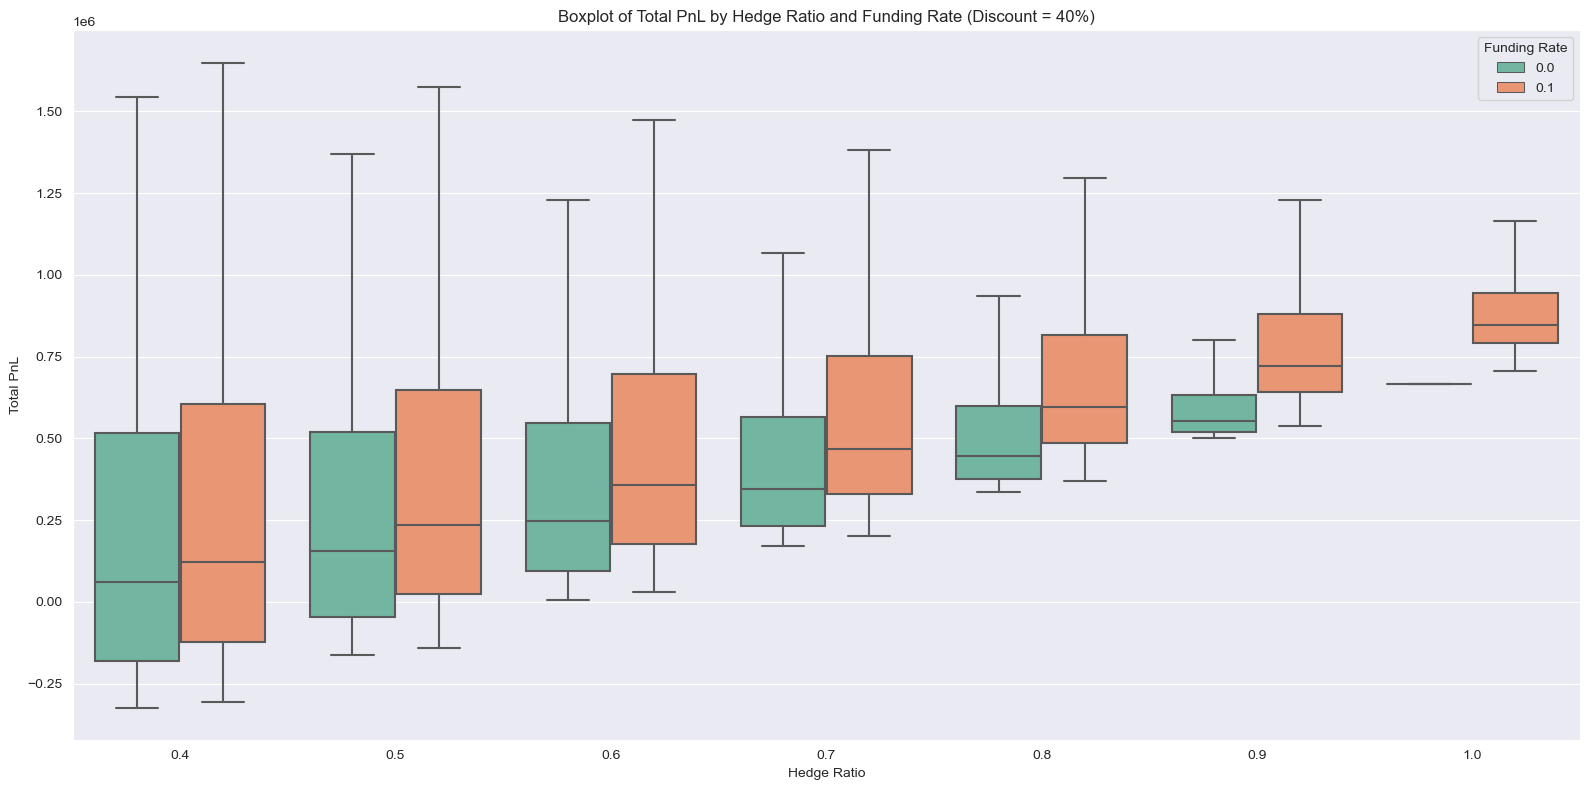

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for easier handling (flatten the dictionary)
all_results = []
for key in sorted(detailed_ann_irr.keys()):
    disc, hedg, fund = key
    ann_irr_values = detailed_ann_irr[key]
    pnl_values = detailed_pnl[key]
    
    # Add results to the DataFrame
    for ann_irr, pnl in zip(ann_irr_values, pnl_values):
        all_results.append({
            "discount": disc,
            "hedge_ratio": hedg,
            "funding_rate": fund,
            "Annualized_IRR": ann_irr,
            "Total_PnL": pnl
        })

# Convert to DataFrame
results_df_box = pd.DataFrame(all_results)

# Filter the DataFrame for 30% discount
results_df_box_filtered = results_df_box[results_df_box['discount'] == 0.4]

# Filter only for funding rates 0.0 and 0.1
results_df_box_filtered = results_df_box_filtered[results_df_box_filtered['funding_rate'].isin([0.0, 0.1])]

# Set the figure size
plt.figure(figsize=(16, 8))

# Create a boxplot for Annualized IRR
sns.boxplot(x="hedge_ratio", y="Annualized_IRR", hue="funding_rate", data=results_df_box_filtered, 
            palette="Set2", showfliers=False)
plt.title("Boxplot of Annualized IRR by Hedge Ratio and Funding Rate (Discount = 40%)")
plt.xlabel("Hedge Ratio")
plt.ylabel("Annualized IRR")
plt.legend(title="Funding Rate")
plt.tight_layout()
plt.show()

# Create a boxplot for Total PnL
plt.figure(figsize=(16, 8))
sns.boxplot(x="hedge_ratio", y="Total_PnL", hue="funding_rate", data=results_df_box_filtered, 
            palette="Set2", showfliers=False)
plt.title("Boxplot of Total PnL by Hedge Ratio and Funding Rate (Discount = 40%)")
plt.xlabel("Hedge Ratio")
plt.ylabel("Total PnL")
plt.legend(title="Funding Rate")
plt.tight_layout()
plt.show()


In [157]:
import pandas as pd
from tabulate import tabulate

# Function to get the best hedge_ratio based on a given metric (e.g., avg IRR, median IRR, etc.)
def get_best_hedge_ratio(df, metric='median_total_PnL'):
    best_hedge_ratio = {}

    # Group by discount and funding rate to find the best hedge ratio for each combination
    for (discount, funding_rate) in df[['discount', 'funding_rate']].drop_duplicates().values:
        # Filter results for the given discount and funding rate
        discount_funding_group = df[(df['discount'] == discount) & (df['funding_rate'] == funding_rate)]
        
        # Get the best hedge ratio by selecting the row with the highest value for the given metric
        best_row = discount_funding_group.loc[discount_funding_group[metric].idxmax()]
        
        # Store the best hedge ratio
        best_hedge_ratio[(discount, funding_rate)] = best_row['hedge_ratio']
    
    return best_hedge_ratio

# Find the best hedge ratio based on the average IRR for each discount and funding rate
best_hedge_ratio_avg_irr = get_best_hedge_ratio(results_df, metric='avg_Annualized_IRR')

# Convert the results into a DataFrame for easy display
best_hedge_ratio_df = pd.DataFrame.from_dict(best_hedge_ratio_avg_irr, orient='index', columns=['best_hedge_ratio'])

# Reset the index to separate discount and funding rate
best_hedge_ratio_df.reset_index(inplace=True)


# Use tabulate to print the results in a nice table format
print("Best Hedge Ratio Based on Median PnL for Each (Funding Rate, Discount) Combination:")
print(tabulate(best_hedge_ratio_df, headers='keys', tablefmt='psql', floatfmt=".2f"))

Best Hedge Ratio Based on Median PnL for Each (Funding Rate, Discount) Combination:
+----+-------------+--------------------+
|    | index       |   best_hedge_ratio |
|----+-------------+--------------------|
|  0 | (0.3, -0.2) |               0.90 |
|  1 | (0.3, -0.1) |               1.00 |
|  2 | (0.3, 0.0)  |               1.00 |
|  3 | (0.3, 0.1)  |               1.00 |
|  4 | (0.3, 0.2)  |               1.00 |
|  5 | (0.4, -0.2) |               0.70 |
|  6 | (0.4, -0.1) |               1.00 |
|  7 | (0.4, 0.0)  |               1.00 |
|  8 | (0.4, 0.1)  |               1.00 |
|  9 | (0.4, 0.2)  |               1.00 |
| 10 | (0.5, -0.2) |               0.40 |
| 11 | (0.5, -0.1) |               0.80 |
| 12 | (0.5, 0.0)  |               1.00 |
| 13 | (0.5, 0.1)  |               1.00 |
| 14 | (0.5, 0.2)  |               1.00 |
+----+-------------+--------------------+


In [166]:
from tabulate import tabulate

# Create a pivot table for median IRR
sensitivity_table_pnl = results_df.pivot_table(
    index=["discount", "hedge_ratio"],
    columns="funding_rate",
    values="median_Annualized_IRR",
)

# Set index names
sensitivity_table_pnl.index.names = ["Discount", "Hedge Ratio"]

# Reset the index to make the index columns regular columns
sensitivity_table_pnl_reset = sensitivity_table_pnl.reset_index()

# Print the Sensitivity Table: Median IRR
print("Sensitivity Table: Median IRR ")
print(tabulate(sensitivity_table_pnl_reset, headers="keys", tablefmt="psql", floatfmt=".2f"))


Sensitivity Table: Median IRR 
+----+------------+---------------+--------+--------+-------+-------+-------+
|    |   Discount |   Hedge Ratio |   -0.2 |   -0.1 |   0.0 |   0.1 |   0.2 |
|----+------------+---------------+--------+--------+-------+-------+-------|
|  0 |       0.30 |          0.40 |  -0.12 |  -0.09 | -0.06 | -0.02 |  0.01 |
|  1 |       0.30 |          0.50 |  -0.09 |  -0.05 | -0.01 |  0.04 |  0.08 |
|  2 |       0.30 |          0.60 |  -0.06 |  -0.01 |  0.04 |  0.09 |  0.15 |
|  3 |       0.30 |          0.70 |  -0.03 |   0.02 |  0.08 |  0.14 |  0.21 |
|  4 |       0.30 |          0.80 |   0.01 |   0.06 |  0.12 |  0.19 |  0.27 |
|  5 |       0.30 |          0.90 |   0.04 |   0.10 |  0.16 |  0.24 |  0.32 |
|  6 |       0.30 |          1.00 |   0.05 |   0.12 |  0.19 |  0.28 |  0.36 |
|  7 |       0.40 |          0.40 |  -0.04 |   0.00 |  0.04 |  0.08 |  0.12 |
|  8 |       0.40 |          0.50 |  -0.01 |   0.04 |  0.09 |  0.14 |  0.19 |
|  9 |       0.40 |          0.60

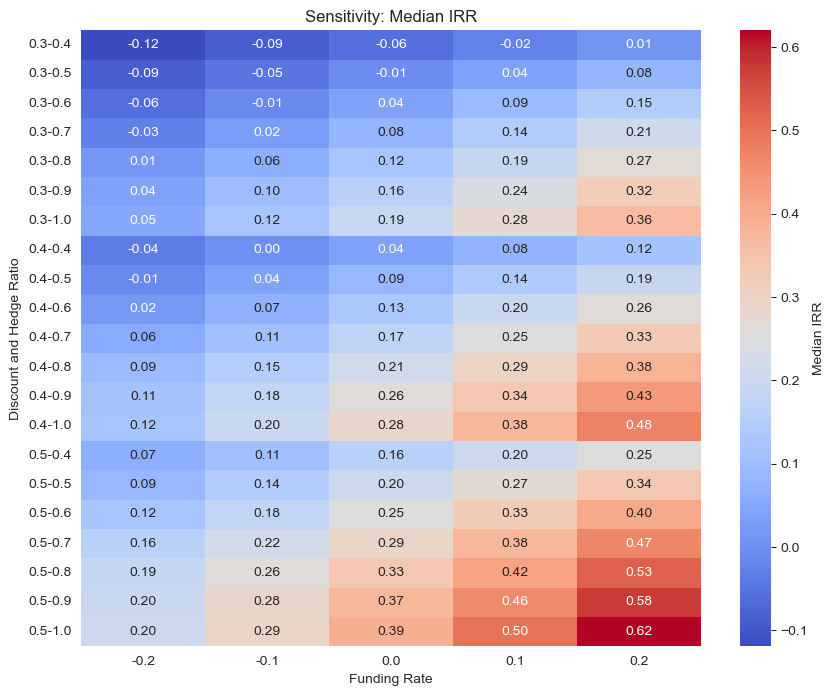

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sensitivity_table_pnl is a pivot table with "discount" and "hedge_ratio" as indices
plt.figure(figsize=(10, 8))
sns.heatmap(sensitivity_table_pnl, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Median IRR'})
plt.title('Sensitivity: Median IRR')
plt.xlabel('Funding Rate')
plt.ylabel('Discount and Hedge Ratio')
plt.show()


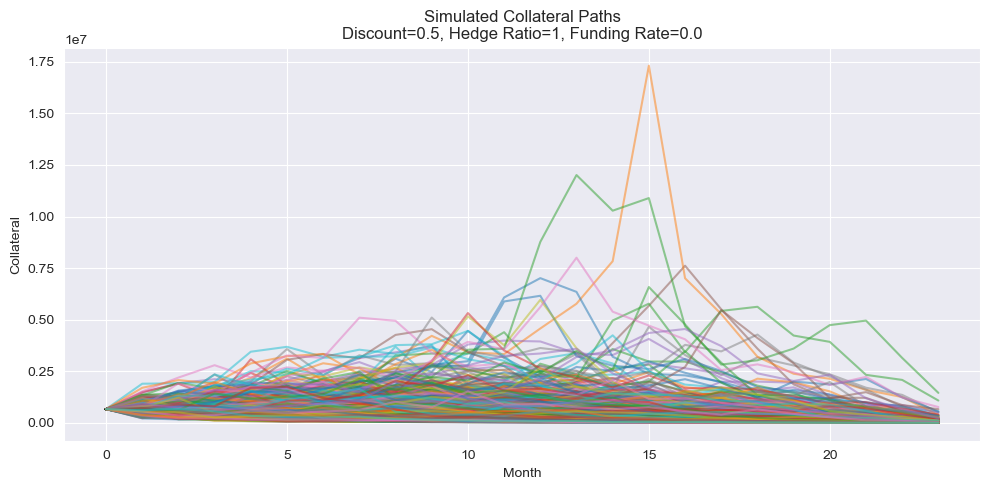

Descriptive Statistics for Collateral Paths (by Month):
        Mean    Median       Std       Min         Max
0  666666.67 666666.67      0.00 666666.67   666666.67
1  667631.75 645347.34 200297.27 217928.30  1897411.32
2  658225.11 602769.18 279787.70 167472.44  2195037.77
3  656027.91 577817.27 347721.28 107146.78  2794595.95
4  645298.40 564075.11 404416.03  82384.41  3448316.04
5  645086.74 547525.65 458432.14  46587.51  3685810.23
6  628034.27 516932.43 464988.83  51325.54  3341718.74
7  625182.82 476517.55 524114.22  45232.21  5097317.07
8  615625.70 436374.27 571449.40  42266.87  4946288.12
9  607559.20 426880.17 606136.72  32669.29  5105107.78
10 588668.85 408179.07 616585.72  27867.72  5322420.30
11 576492.75 384185.05 626043.09  24784.16  6077906.26
12 561371.49 364396.82 695042.54  18010.31  8769397.04
13 528327.60 322508.92 732768.92   8224.96 12011309.68
14 471592.27 273345.65 667364.46   8911.15 10283919.17
15 442200.85 232921.54 858098.94   6704.89 17311357.08
16 371746

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Choose the parameter key you want to inspect.
selected_key = (0.5, 1, 0.0)  # adjust as needed

# Retrieve collateral paths for that key.
collateral_paths = detailed_collateral[selected_key]

# Plot a subset of collateral paths for visual inspection.
plt.figure(figsize=(10, 5))
for c in collateral_paths[:1000]:  # Plot first 20 runs for clarity.
    plt.plot(c, alpha=0.5)
plt.title(f"Simulated Collateral Paths\nDiscount={selected_key[0]}, Hedge Ratio={selected_key[1]}, Funding Rate={selected_key[2]}")
plt.xlabel("Month")
plt.ylabel("Collateral")
plt.grid(True)
plt.tight_layout()
plt.show()

# Convert the list of collateral paths to a 2D NumPy array.
# Assuming each path is of the same length (number of months).
collateral_arr = np.array(collateral_paths)

# Compute descriptive statistics for each month (column-wise).
stats_df = pd.DataFrame({
    'Mean': np.mean(collateral_arr, axis=0),
    'Median': np.median(collateral_arr, axis=0),
    'Std': np.std(collateral_arr, axis=0),
    'Min': np.min(collateral_arr, axis=0),
    'Max': np.max(collateral_arr, axis=0)
})

print("Descriptive Statistics for Collateral Paths (by Month):")
print(stats_df)

In [130]:
grouped_collateral = {}
for key, collateral_paths in detailed_collateral.items():
    hedge = key[1]  # hedge ratio
    funding_rate = key[2]  # assume first element of key is the funding rate

    # Create a nested dictionary structure to group by both hedge_ratio and funding_rate
    if (hedge, funding_rate) not in grouped_collateral:
        grouped_collateral[(hedge, funding_rate)] = []

    for path in collateral_paths:
        grouped_collateral[(hedge, funding_rate)].extend(path)

# Aggregate statistics for each (hedge_ratio, funding_rate) pair in a dictionary.
stats_dict = {}
for (hedge, funding_rate), coll_list in grouped_collateral.items():
    all_coll = np.array(coll_list)
    stats_dict[(hedge, funding_rate)] = {
        "Mean": np.mean(all_coll),
        "Median": np.median(all_coll),
        "Min": np.min(all_coll),
        "Max": np.max(all_coll),
        "Std": np.std(all_coll),
        "5th %ile": np.percentile(all_coll, 5),
        "95th %ile": np.percentile(all_coll, 95)
    }

# Convert the stats dictionary into a DataFrame for a tidy table.
stats_df = pd.DataFrame(stats_dict).T  # transpose so each row is a (hedge ratio, funding rate) pair
stats_df.index = pd.MultiIndex.from_tuples(stats_df.index, names=["Hedge Ratio", "Funding Rate"])

# Use tabulate to print the DataFrame in a better table format
print("Descriptive Statistics for Collateral Paths (by Hedge Ratio and Funding Rate):")
print(tabulate(stats_df, headers='keys', tablefmt='psql', floatfmt='.2f'))

Descriptive Statistics for Collateral Paths (by Hedge Ratio and Funding Rate):
+-------------+-----------+-----------+--------+-------------+-----------+------------+-------------+
|             |      Mean |    Median |    Min |         Max |       Std |   5th %ile |   95th %ile |
|-------------+-----------+-----------+--------+-------------+-----------+------------+-------------|
| (0.4, -0.2) | 130484.26 |  84903.00 |   0.00 |  3212902.23 | 165960.44 |       0.00 |   409144.49 |
| (0.4, -0.1) | 130484.26 |  84903.00 |   0.00 |  3212902.23 | 165960.44 |       0.00 |   409144.49 |
| (0.4, 0.0)  | 130484.26 |  84903.00 |   0.00 |  3212902.23 | 165960.44 |       0.00 |   409144.49 |
| (0.4, 0.1)  | 130484.26 |  84903.00 |   0.00 |  3212902.23 | 165960.44 |       0.00 |   409144.49 |
| (0.4, 0.2)  | 130484.26 |  84903.00 |   0.00 |  3212902.23 | 165960.44 |       0.00 |   409144.49 |
| (0.5, -0.2) | 168858.59 | 114241.25 |   0.00 |  4477485.69 | 210325.70 |       0.00 |   518477.95 |
| (

--- Simulated Price Stats (All Runs & All Time) ---
Mean price     : 0.6884
Median price   : 0.5025
Min price      : 0.0016
Max price      : 22.3034
Std deviation  : 0.8624
5th percentile : 0.0602
95th percentile: 1.8820


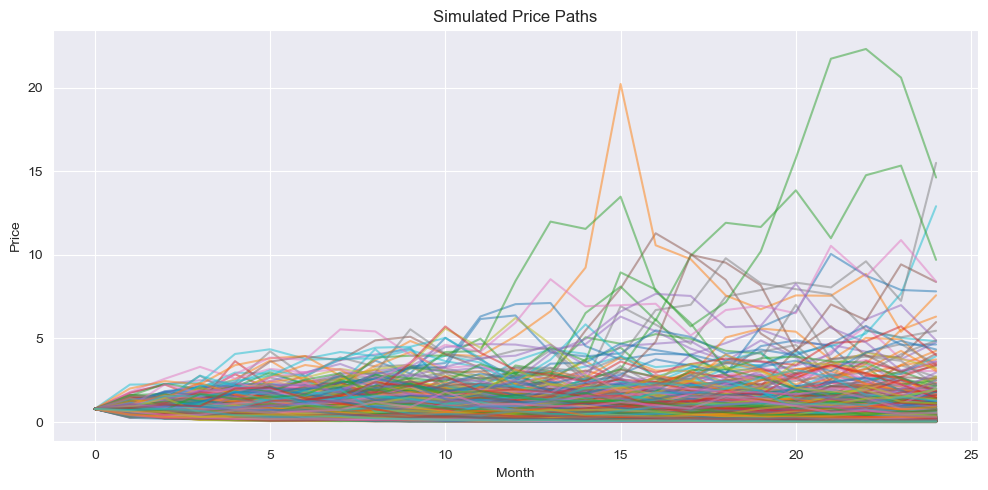

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Select the parameter key to inspect.
selected_key = (0.3, 0.8, 0.0)  # adjust as needed

# Retrieve all price paths for that key.
price_paths = detailed_prices[selected_key]

# Flatten all the price values across all runs and time steps.
all_prices = np.concatenate(price_paths)

# Compute descriptive statistics across all prices.
mean_price    = np.mean(all_prices)
median_price  = np.median(all_prices)
min_price     = np.min(all_prices)
max_price     = np.max(all_prices)
std_price     = np.std(all_prices)
p5            = np.percentile(all_prices, 5)
p95           = np.percentile(all_prices, 95)

# Print out the statistics.
print("--- Simulated Price Stats (All Runs & All Time) ---")
print(f"Mean price     : {mean_price:.4f}")
print(f"Median price   : {median_price:.4f}")
print(f"Min price      : {min_price:.4f}")
print(f"Max price      : {max_price:.4f}")
print(f"Std deviation  : {std_price:.4f}")
print(f"5th percentile : {p5:.4f}")
print(f"95th percentile: {p95:.4f}")
# Plot common price paths from the pre-generated shocks:
plt.figure(figsize=(10, 5))
for run in range(1000):  # or a subset if you prefer
    # Get a price path from one simulation using the common shocks
    # (Assume using one parameter combination, e.g., key=(0.35, 0.8, 0.0))
    prices = detailed_prices[(0.3, 0.8, 0.0)][run]
    plt.plot(prices, alpha=0.5)
plt.title("Simulated Price Paths")
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


In [134]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
from scipy.stats import t as student_t

# Assume simulate_strategy is defined as above and accepts an external_shocks parameter.

# Fixed simulation parameters.
P0 = 0.7874
investment_unit = 1.0  # We'll simulate using an investment of 1 unit.
T = 24                # Simulation horizon in months.
annual_vol = 1.0125
annual_funding_rate = 0.2  # Fixed funding rate for this analysis.
cliff_months = 12
price_floor = None
num_runs = 1000

# Sensitivity parameter ranges (only vary discount and hedge_ratio for this exercise).
discounts = np.linspace(0.3, 0.5, 3)   # Example: 0.2, 0.35, 0.5
hedge_ratios = np.linspace(0.4, 1, 7)    # e.g. 0, 0.5, 1.0

# Pre-generate a common set of shocks for each run.
df_t = 20.0   # Use a higher df to reduce extreme tails.
skew_strength = 0.0
common_shocks = {}
for run in range(num_runs):
    shocks = student_t.rvs(df_t, size=T)
    shocks /= np.sqrt(df_t / (df_t - 2))
    shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))
    common_shocks[run] = shocks

def run_unit_simulation(discount, hedge_ratio, run):
    # Use pre-generated shocks for this run.
    external_shocks = common_shocks[run]
    res = simulate_strategy(
        P0=P0,
        investment_amount=investment_unit,  # unit investment
        discount=discount,
        hedge_ratio=hedge_ratio,
        T=T,
        annual_vol=annual_vol,
        annual_funding_rate=annual_funding_rate,
        cliff_months=cliff_months,
        price_floor=price_floor,
        seed=None,  # seed is not used since we pass external_shocks
        external_shocks=external_shocks,
        maint_margin_data=manual_eosusdt_tiers 
    )
    # For each simulation run, compute the maximum collateral used over the simulation.
    # collateral_series is a list of collateral values (one per month).
    max_collateral = np.max(res["collateral_series"]) if res["collateral_series"] else 0.0
    return max_collateral

# For each combination of discount and hedge_ratio, compute the 95th percentile of max collateral ratios.
results_coll = []
for discount in discounts:
    for hedge_ratio in hedge_ratios:
        # Run the unit simulation for all runs for this combination.
        max_collaterals = Parallel(n_jobs=-1)(
            delayed(run_unit_simulation)(discount, hedge_ratio, run)
            for run in range(num_runs)
        )
        max_collaterals = np.array(max_collaterals)
        # 95th percentile collateral ratio (collateral per unit investment)
        ratio_95 = np.percentile(max_collaterals, 95)
        # Maximum investment to keep collateral under $5M.
        max_investment = 5_000_000 / ratio_95 if ratio_95 > 0 else np.nan
        results_coll.append({
            "discount": discount,
            "hedge_ratio": hedge_ratio,
            "95th_percentile_ratio": ratio_95,
            "max_investment": max_investment
        })

results_coll = pd.DataFrame(results_coll)
print("Maximum Investment to Keep Collateral Under $5M at 95% Confidence:")
print(results_coll)


Maximum Investment to Keep Collateral Under $5M at 95% Confidence:
    discount  hedge_ratio  95th_percentile_ratio  max_investment
0       0.30         0.40                   0.76      6558067.25
1       0.30         0.50                   0.95      5245297.62
2       0.30         0.60                   1.16      4302531.90
3       0.30         0.70                   1.36      3667021.29
4       0.30         0.80                   1.56      3208643.63
5       0.30         0.90                   1.75      2852127.67
6       0.30         1.00                   1.95      2566914.90
7       0.40         0.40                   0.89      5621200.50
8       0.40         0.50                   1.11      4495969.39
9       0.40         0.60                   1.36      3687884.48
10      0.40         0.70                   1.59      3143161.11
11      0.40         0.80                   1.82      2750265.97
12      0.40         0.90                   2.05      2444680.86
13      0.40         1.